In [19]:
if (!require("pacman")) install.packages("pacman")
pkgs = c('forecast', 'timetk', 'vars', 'readxl', 'scales', 
         'MLmetrics', 'lubridate',
         'patchwork', 'hrbrthemes', 'ggthemes', 'ggsci', 'urca', 'tidyverse'
        )
pacman::p_load(pkgs, character.only=TRUE)

options(
  repr.plot.width=10, 
  repr.plot.height=6, 
  repr.plot.res = 300,
  repr.matrix.max.rows = 10,
  repr.matrix.max.cols = Inf
)

## Data Prep

### Production

In [24]:
production = read_excel('../data/rice_production.xlsx', 'all')

production_annual = production %>% 
  group_by(year, rice_type) %>%
  summarize(area_plant = sum(area_plant),
            area_harvest = sum(area_harvest),
            production = sum(production)*0.66 # convert to milled rice
           ) %>%
  mutate(yield_plant = production*1000/area_plant,
         yield_harvest = production*1000/area_harvest,
        ) %>% ungroup()

production_wide = production_annual %>%
  pivot_wider(
    year,
    rice_type,
    values_from = production
  )

names(production_wide) = c(
  'year_th', 'q_pathum', 'q_hommali', 'q_white', 'q_glutinous'
)

production_wide %>% tail()

`summarise()` regrouping output by 'year' (override with `.groups` argument)



year_th,q_pathum,q_hommali,q_white,q_glutinous
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2557,1037038.2,5693006,12490115,5042944
2558,737410.7,5764920,9656676,4708132
2559,664396.3,5796894,7492643,4143932
2560,919589.2,6125247,9470159,4510751
2561,865119.4,5982158,10568502,4297496
2562,1140052.3,5860384,10237382,4111937


### Export

In [12]:
export = read_rds('../data/export_1006_master.rds')
export_meta = read_excel('../data/meta_hs1006_th.xlsx')
export_joined = export %>% left_join(export_meta, by = c('hscode' = 'hscode'))

export_annual = export_joined %>% 
  group_by(year_th, varities) %>%
  summarize(vol = sum(vol)) %>% ungroup()

export_wide = export_annual %>%
  pivot_wider(
    year_th,
    varities,
    values_from = vol
  )

names(export_wide) = c(
  'year_th', 'ex_glutinous', 'ex_white', 
  'ex_hommali', 'ex_pathum', 'ex_colored'
)

head(export_wide)

export_monthly = export_joined %>% 
  group_by(year_th, month, varities) %>%
  summarize(vol = sum(vol)) %>% ungroup()

export_wide_m = export_monthly %>%
  pivot_wider(
    c(year_th, month),
    varities,
    values_from = vol,
    values_fill = 0
  ) %>% filter(year_th >= 2545)

names(export_wide_m) = c(
  'year_th', 'month',
  'ex_glutinous','ex_white','ex_hommali','ex_pathum','ex_colored'
)

`summarise()` regrouping output by 'year_th' (override with `.groups` argument)



year_th,ex_glutinous,ex_white,ex_hommali,ex_pathum,ex_colored
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2541,153566.6,6386668,NA,NA,NA
2542,312107.4,6526685,NA,NA,NA
2543,197486.1,5943855,NA,NA,NA
2544,210633.5,7352968,121449.1,NA,NA
2545,229807.2,5611646,1492995.0,NA,NA
2546,294417.4,4848814,2202739.0,NA,NA


`summarise()` regrouping output by 'year_th', 'month' (override with `.groups` argument)



### Domestic Consumption

In [14]:
data_m = export_wide_m %>% 
  mutate(date = as.Date(paste0(year_th-543, '-', month, '-1')))

# data_a = export_wide %>% 
#   left_join(production_wide, by = 'year_th') %>%
#   mutate(dom_hommali = q_hommali - ex_hommali,
#          dom_pathum = q_pathum - ex_pathum,
#          dom_white = q_white - ex_white,
#          dom_glutinous = q_glutinous - ex_glutinous
#         ) %>%
#   filter(year_th >= 2545)

# save in csv format
# data_a %>% write_excel_csv('../data/rice_a.csv')
data_m %>% write_excel_csv('../data/rice_m.csv')

In [11]:
# export_names = c('ex_glutinous', 'ex_white', 'ex_hommali', 'ex_pathum')
# ts_export = ts(data_m[export_names], start = 2549-543, frequency = 12)

### Read

In [17]:
rice_a = read_csv('../data/rice_a.csv') 
rice_m = read_csv('../data/rice_m.csv')
rice_m_ts = rice_m %>% tk_ts(start = 2545-543, frequency = 12)

Parsed with column specification:
cols(
  year_th = col_double(),
  ex_glutinous = col_double(),
  ex_white = col_double(),
  ex_hommali = col_double(),
  ex_pathum = col_double(),
  ex_colored = col_double(),
  q_pathum = col_double(),
  q_hommali = col_double(),
  q_white = col_double(),
  q_glutinous = col_double(),
  dom_hommali = col_double(),
  dom_pathum = col_double(),
  dom_white = col_double(),
  dom_glutinous = col_double()
)

Parsed with column specification:
cols(
  year_th = col_double(),
  month = col_character(),
  ex_glutinous = col_double(),
  ex_white = col_double(),
  ex_hommali = col_double(),
  ex_pathum = col_double(),
  ex_colored = col_double(),
  date = col_date(format = "")
)

Warning message:
"Non-numeric columns being dropped: month, date"


In [18]:
rice_m_ts

,year_th,ex_glutinous,ex_white,ex_hommali,ex_pathum,ex_colored
Jan 2002,2545,13054.260,665723.1,11889.38,0.000,0.000
Feb 2002,2545,18478.137,451630.1,27416.01,0.000,0.000
Mar 2002,2545,14681.428,547161.8,41099.09,0.000,0.000
Apr 2002,2545,20208.437,525740.0,17749.08,0.000,0.000
May 2002,2545,18239.308,436294.4,46268.54,0.000,0.000
Jun 2002,2545,15290.163,367622.9,144787.19,0.000,0.000
Jul 2002,2545,11146.494,360513.2,173942.57,0.000,0.000
Aug 2002,2545,10924.417,349607.8,222067.55,0.000,0.000
Sep 2002,2545,17600.545,378190.1,162949.33,0.000,0.000
Oct 2002,2545,37717.257,617172.8,158169.93,0.000,0.000


In [16]:
rice_m %>% filter(year_th >= 2543) %>% arrange(year_th)

year_th,month,ex_glutinous,ex_white,ex_hommali,ex_pathum,ex_colored,date
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
2545,01,13054.26,665723.1,11889.38,0,0,2002-01-01
2545,02,18478.14,451630.1,27416.01,0,0,2002-02-01
2545,03,14681.43,547161.8,41099.09,0,0,2002-03-01
2545,04,20208.44,525740.0,17749.08,0,0,2002-04-01
2545,05,18239.31,436294.4,46268.54,0,0,2002-05-01
...,...,...,...,...,...,...,...
2562,08,5470.075,283164.5,105461.6,53798.72,580.804,2019-08-01
2562,09,3753.291,429410.5,102659.0,40384.34,466.939,2019-09-01
2562,10,4615.151,450419.0,95889.8,55231.47,762.916,2019-10-01


## Data Visualization

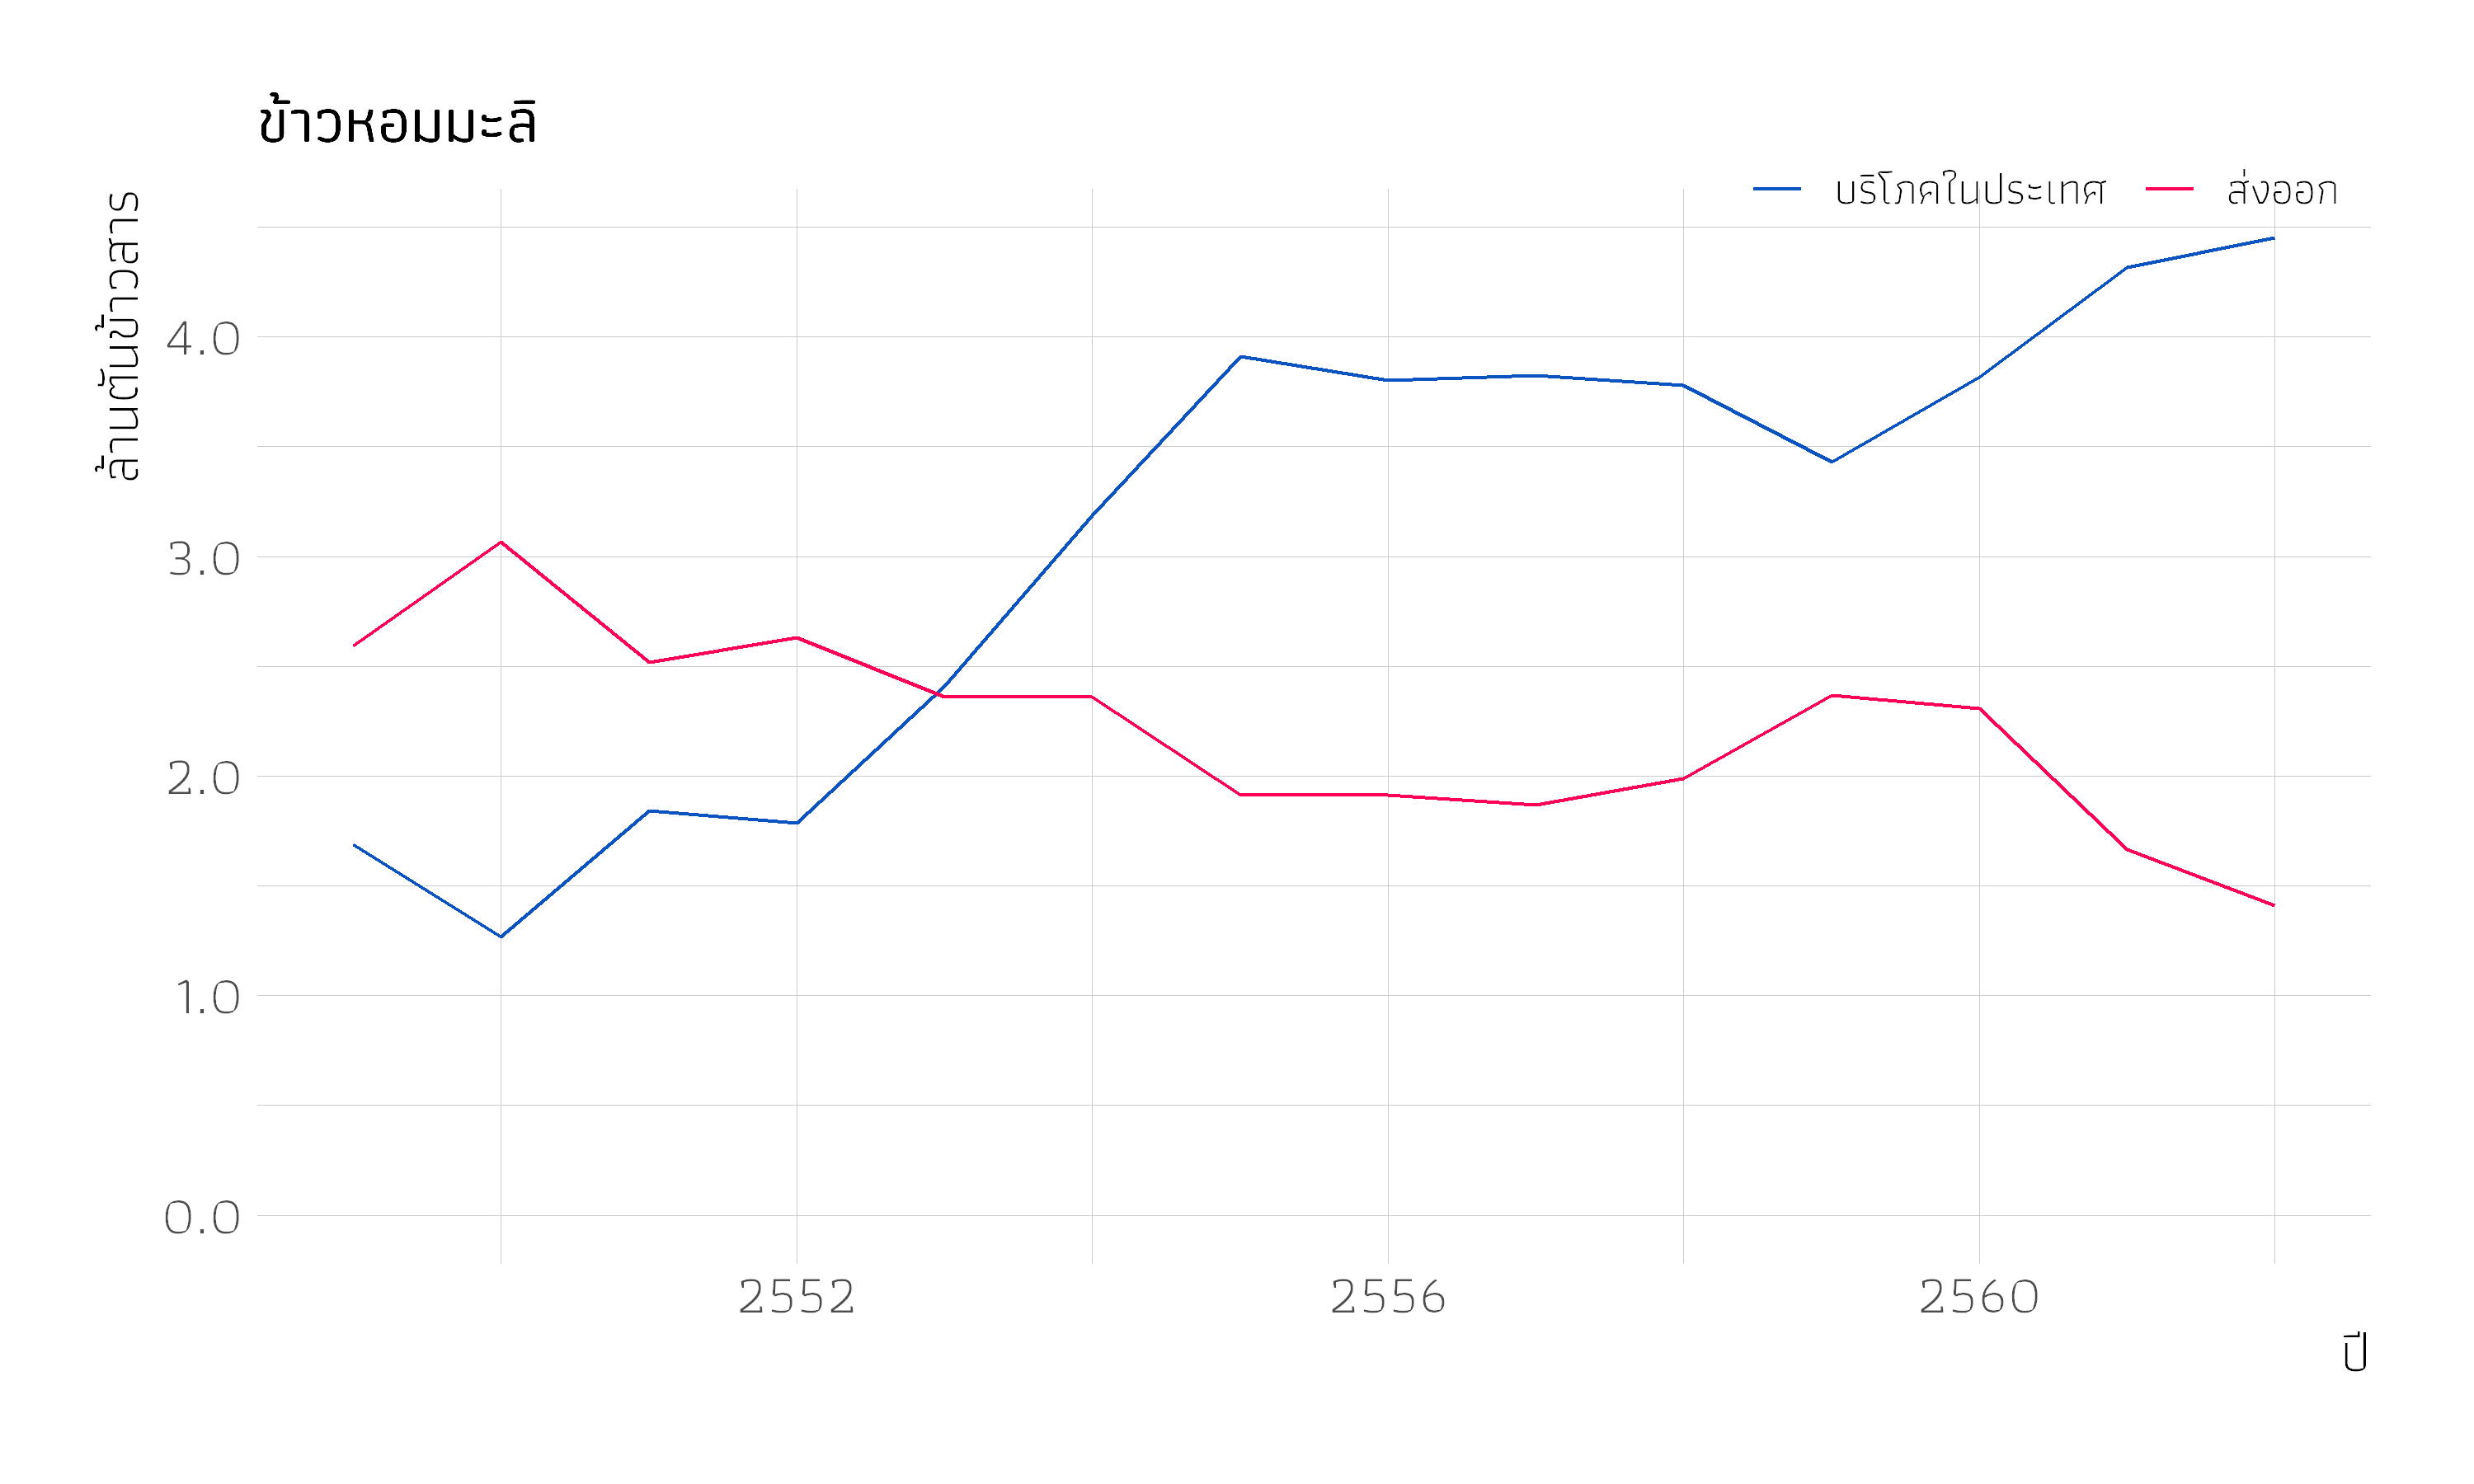

In [35]:
p_hommali = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_hommali/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_hommali/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวหอมมะลิ',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_hommali
ggsave('../figures/plot_hommali.png', width = 8, height = 4)

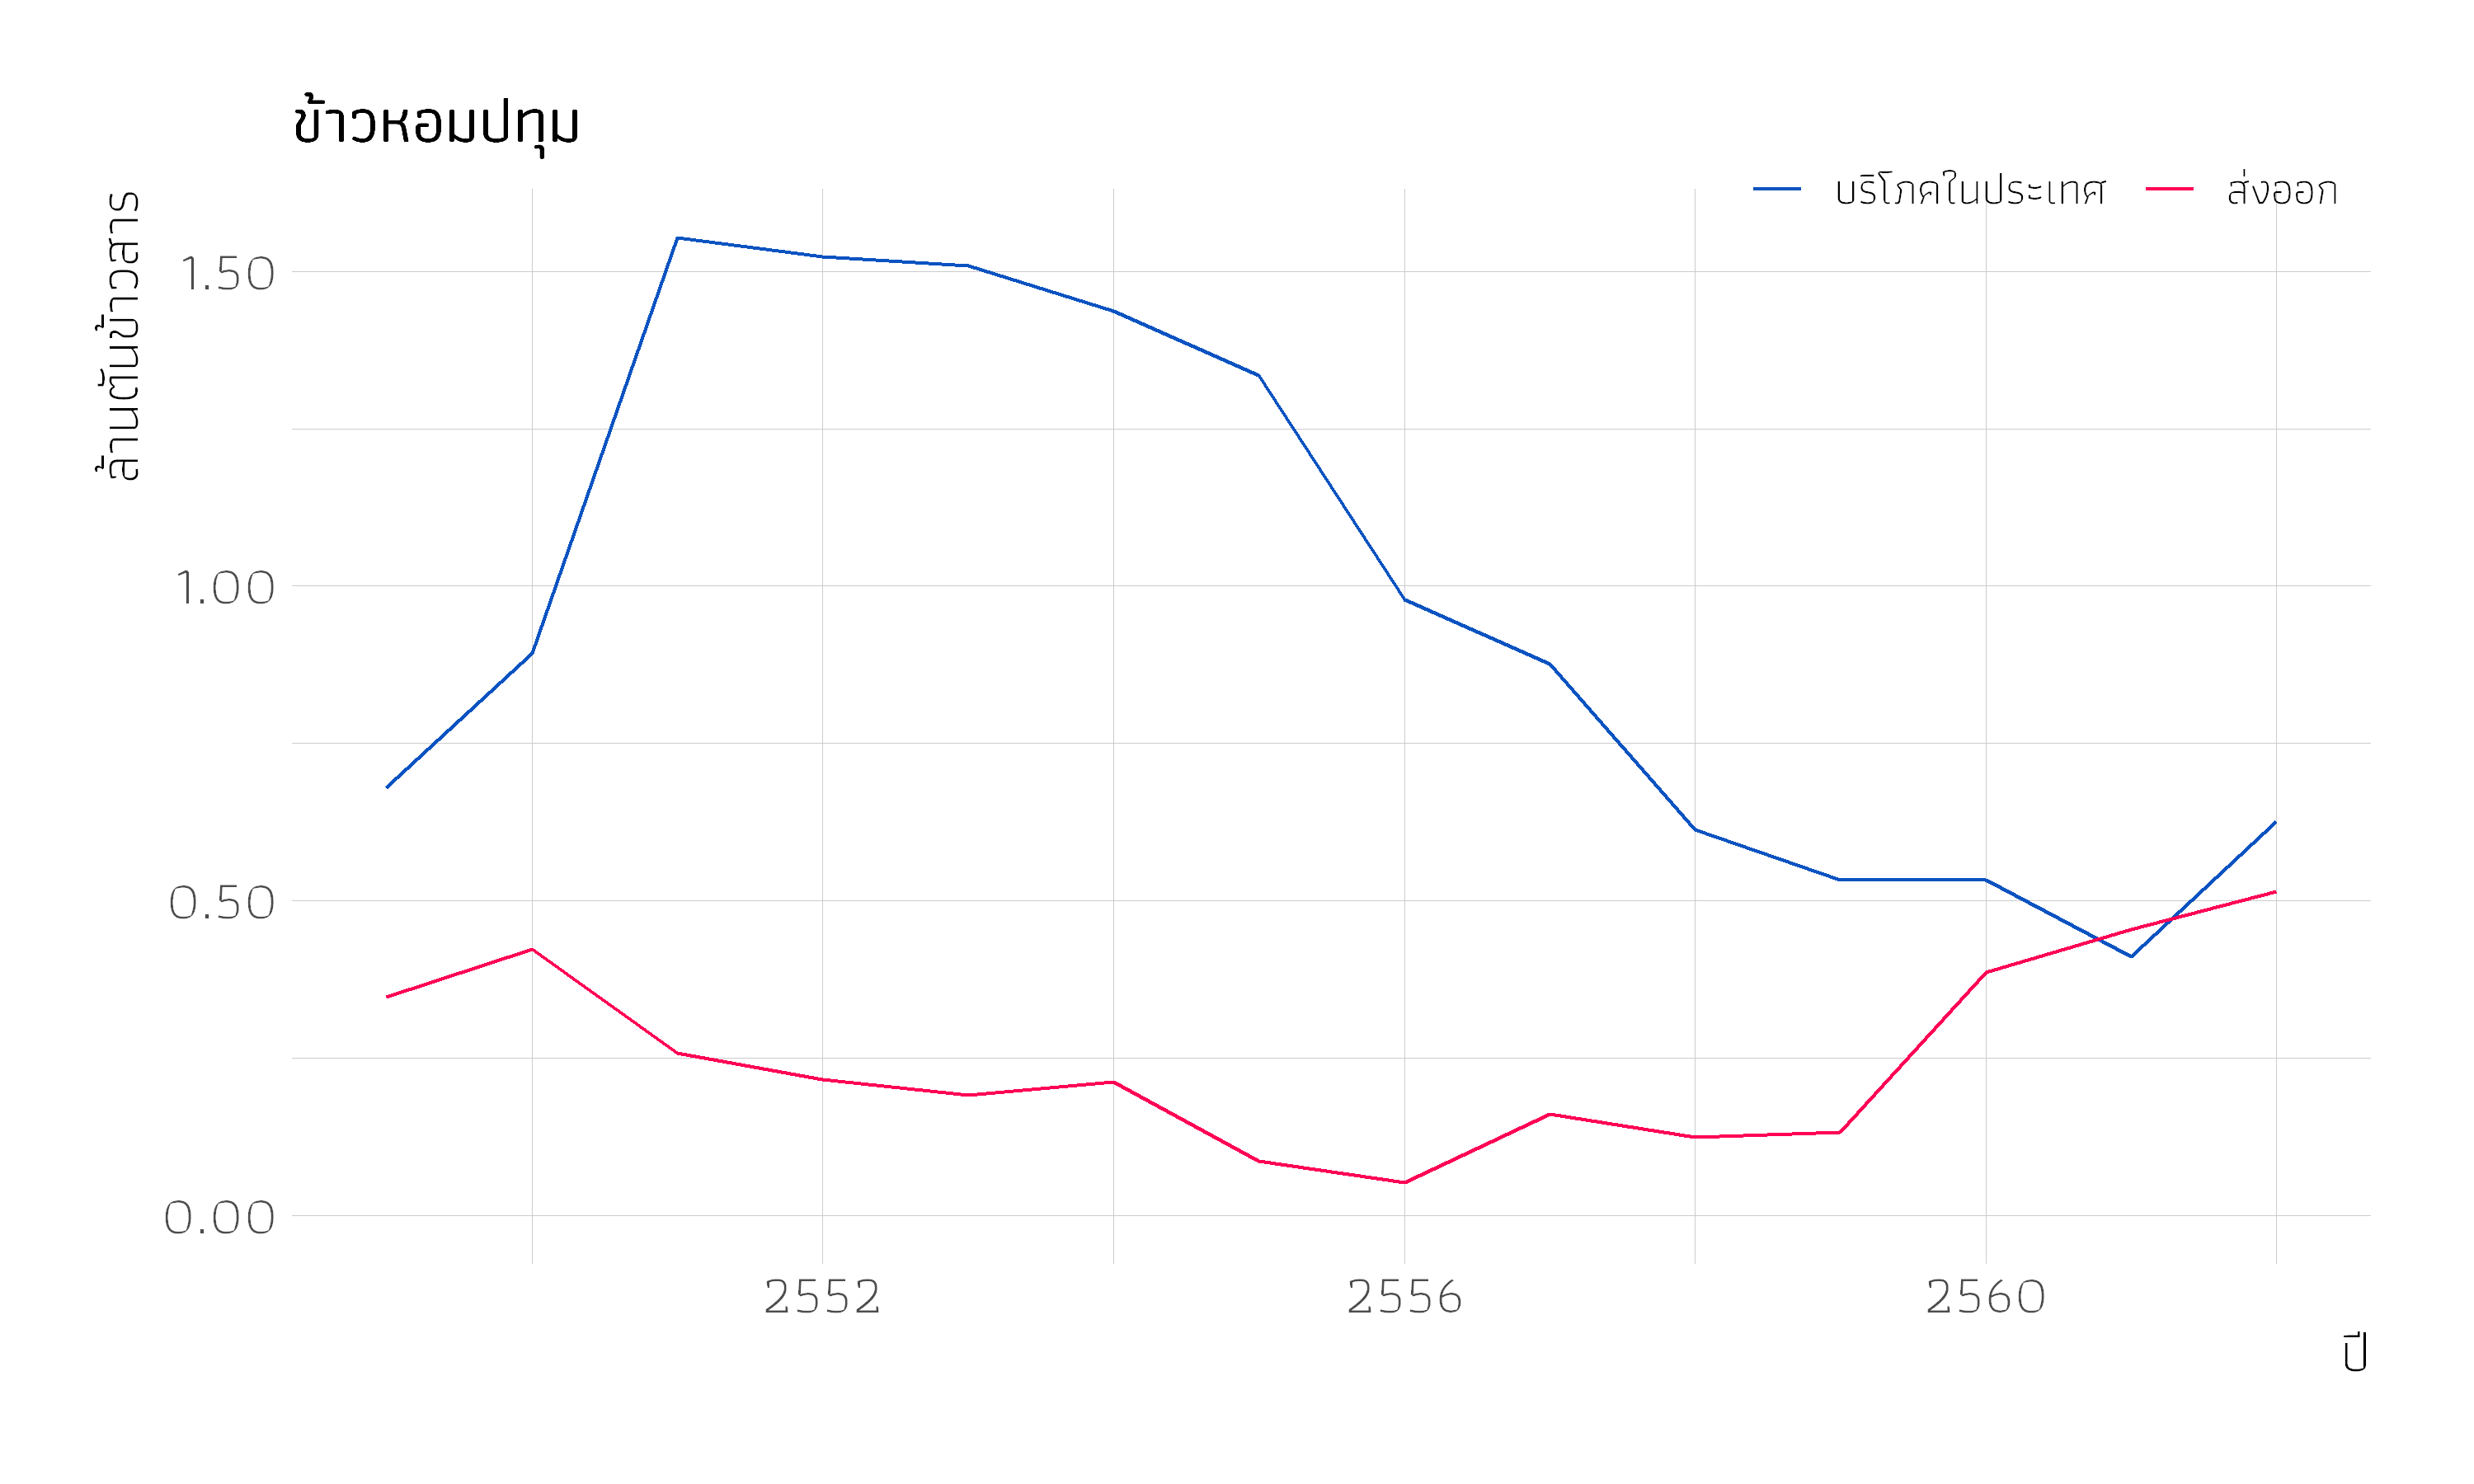

In [37]:
p_pathum = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_pathum/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_pathum/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวหอมปทุม',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_pathum
ggsave('../figures/plot_pathum.png', width = 8, height = 4)

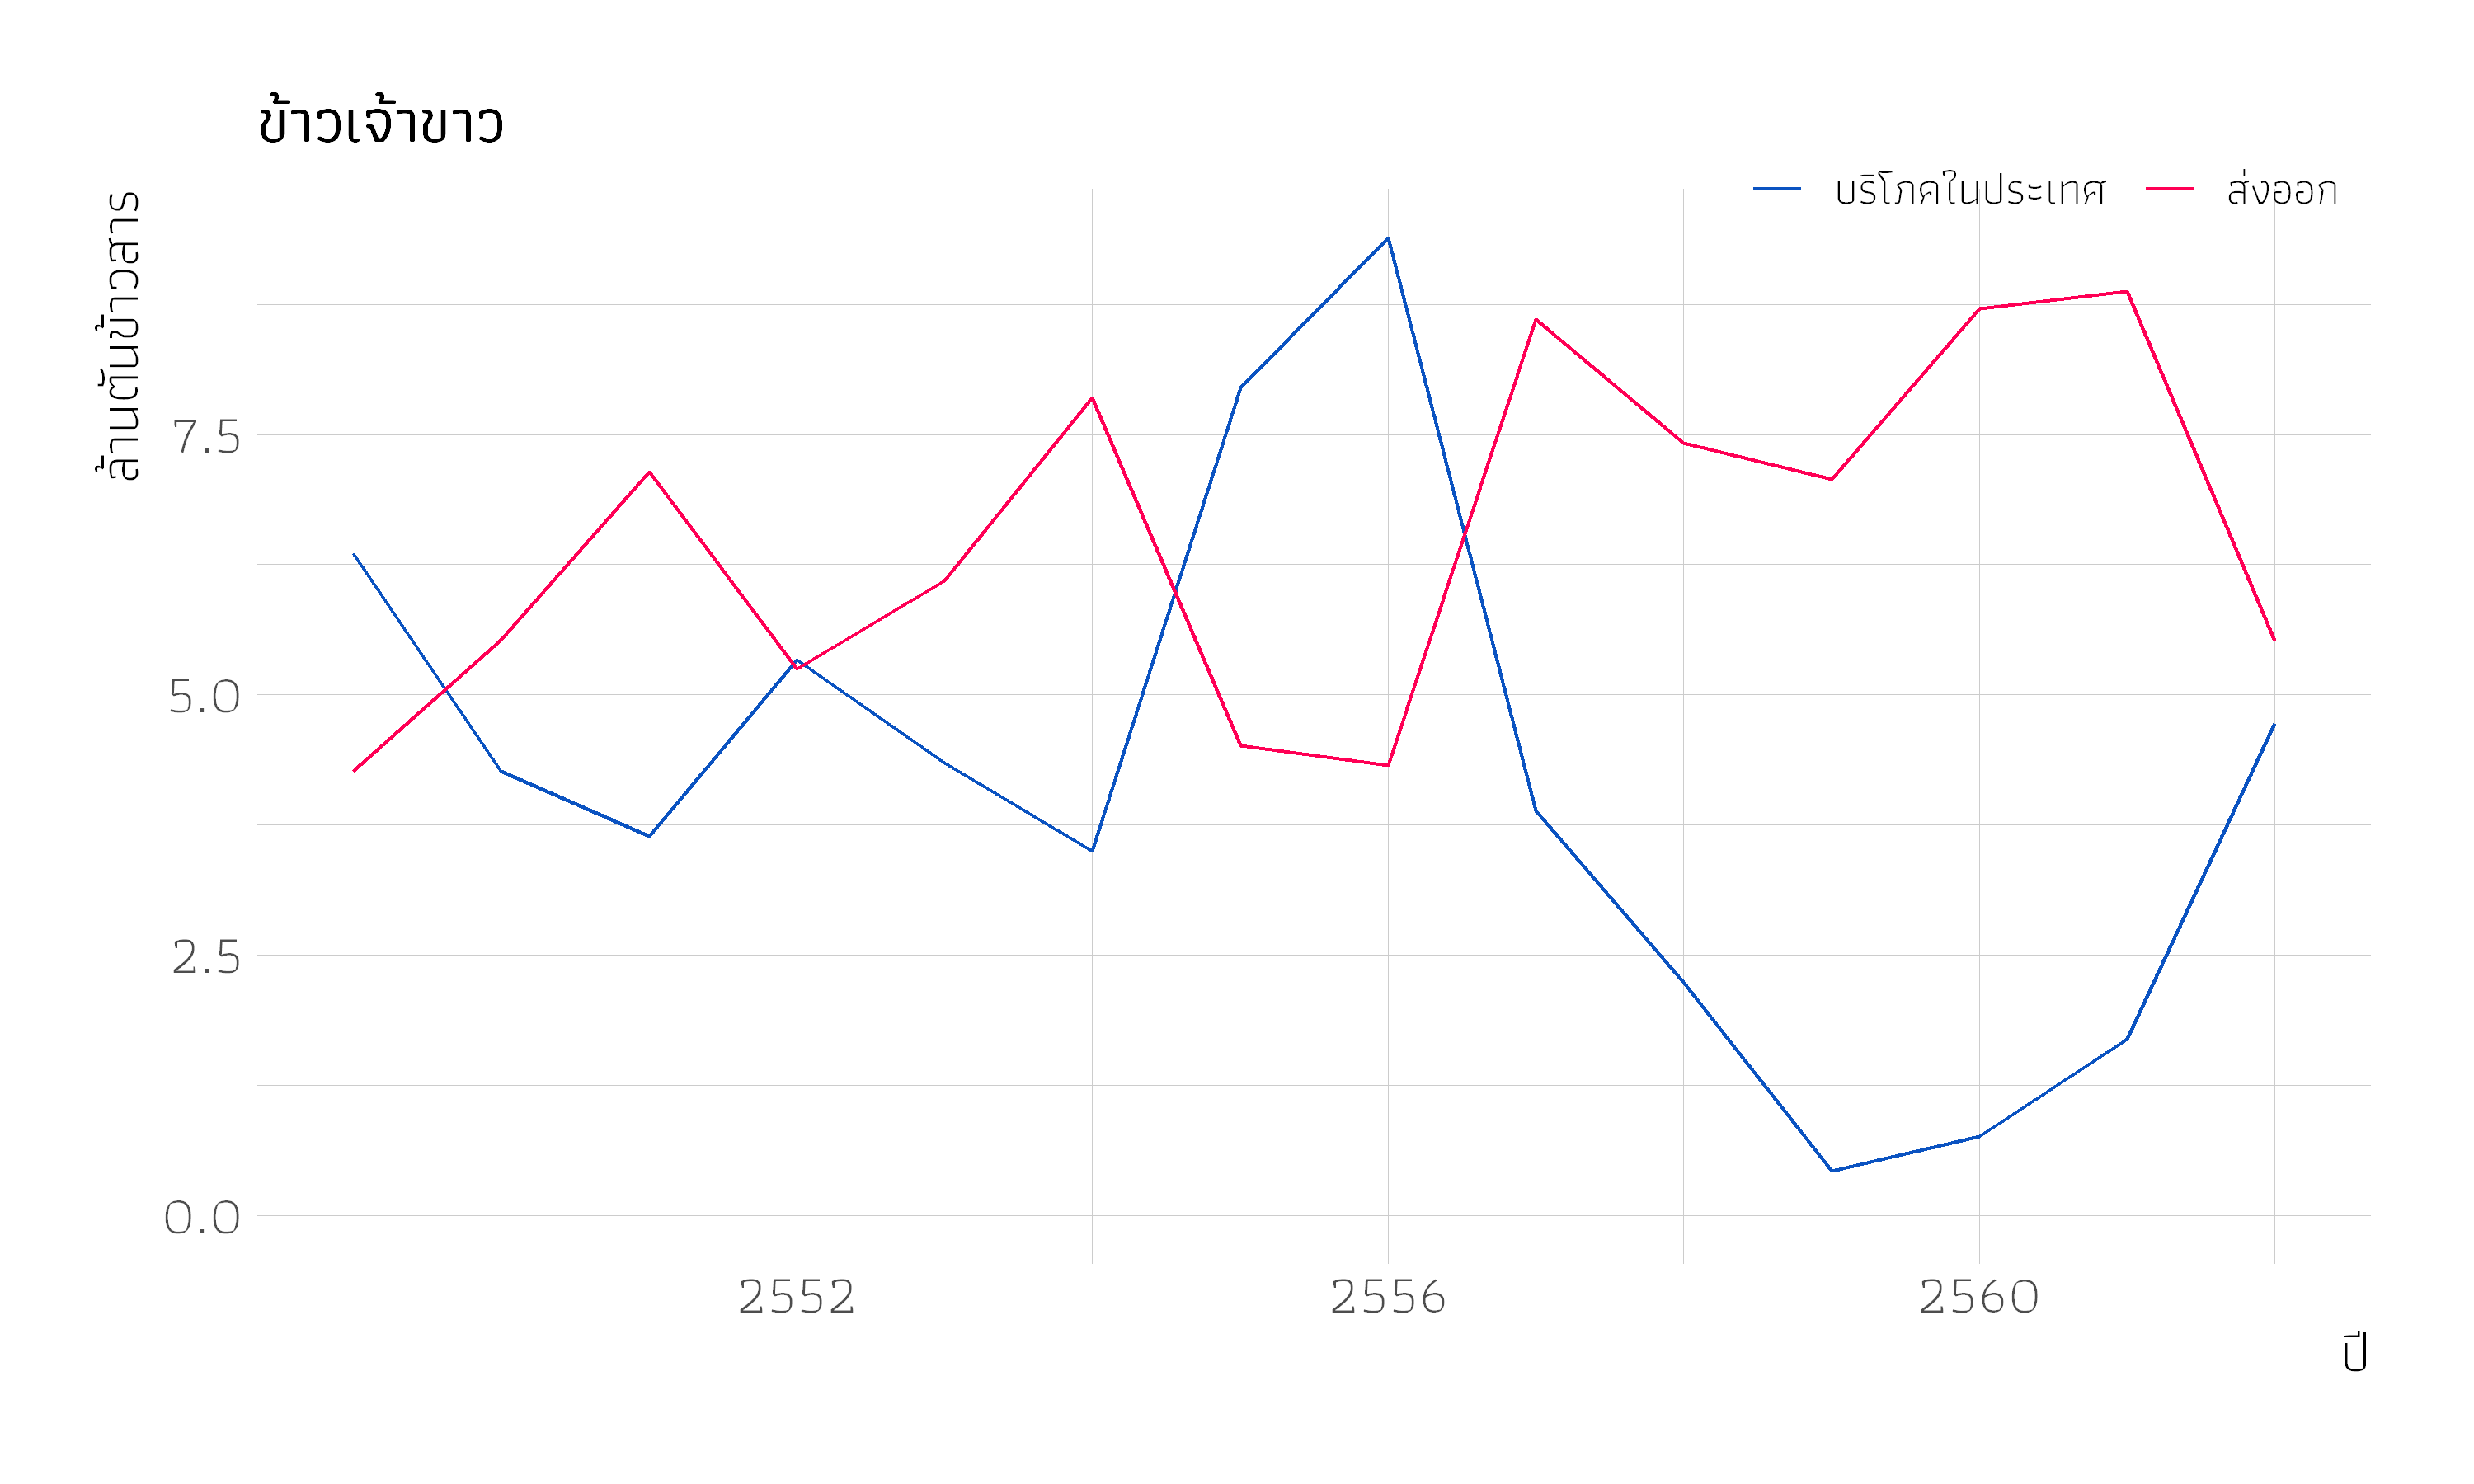

In [38]:
p_white = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_white/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_white/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวเจ้าขาว',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_white
ggsave('../figures/plot_white.png', width = 8, height = 4)

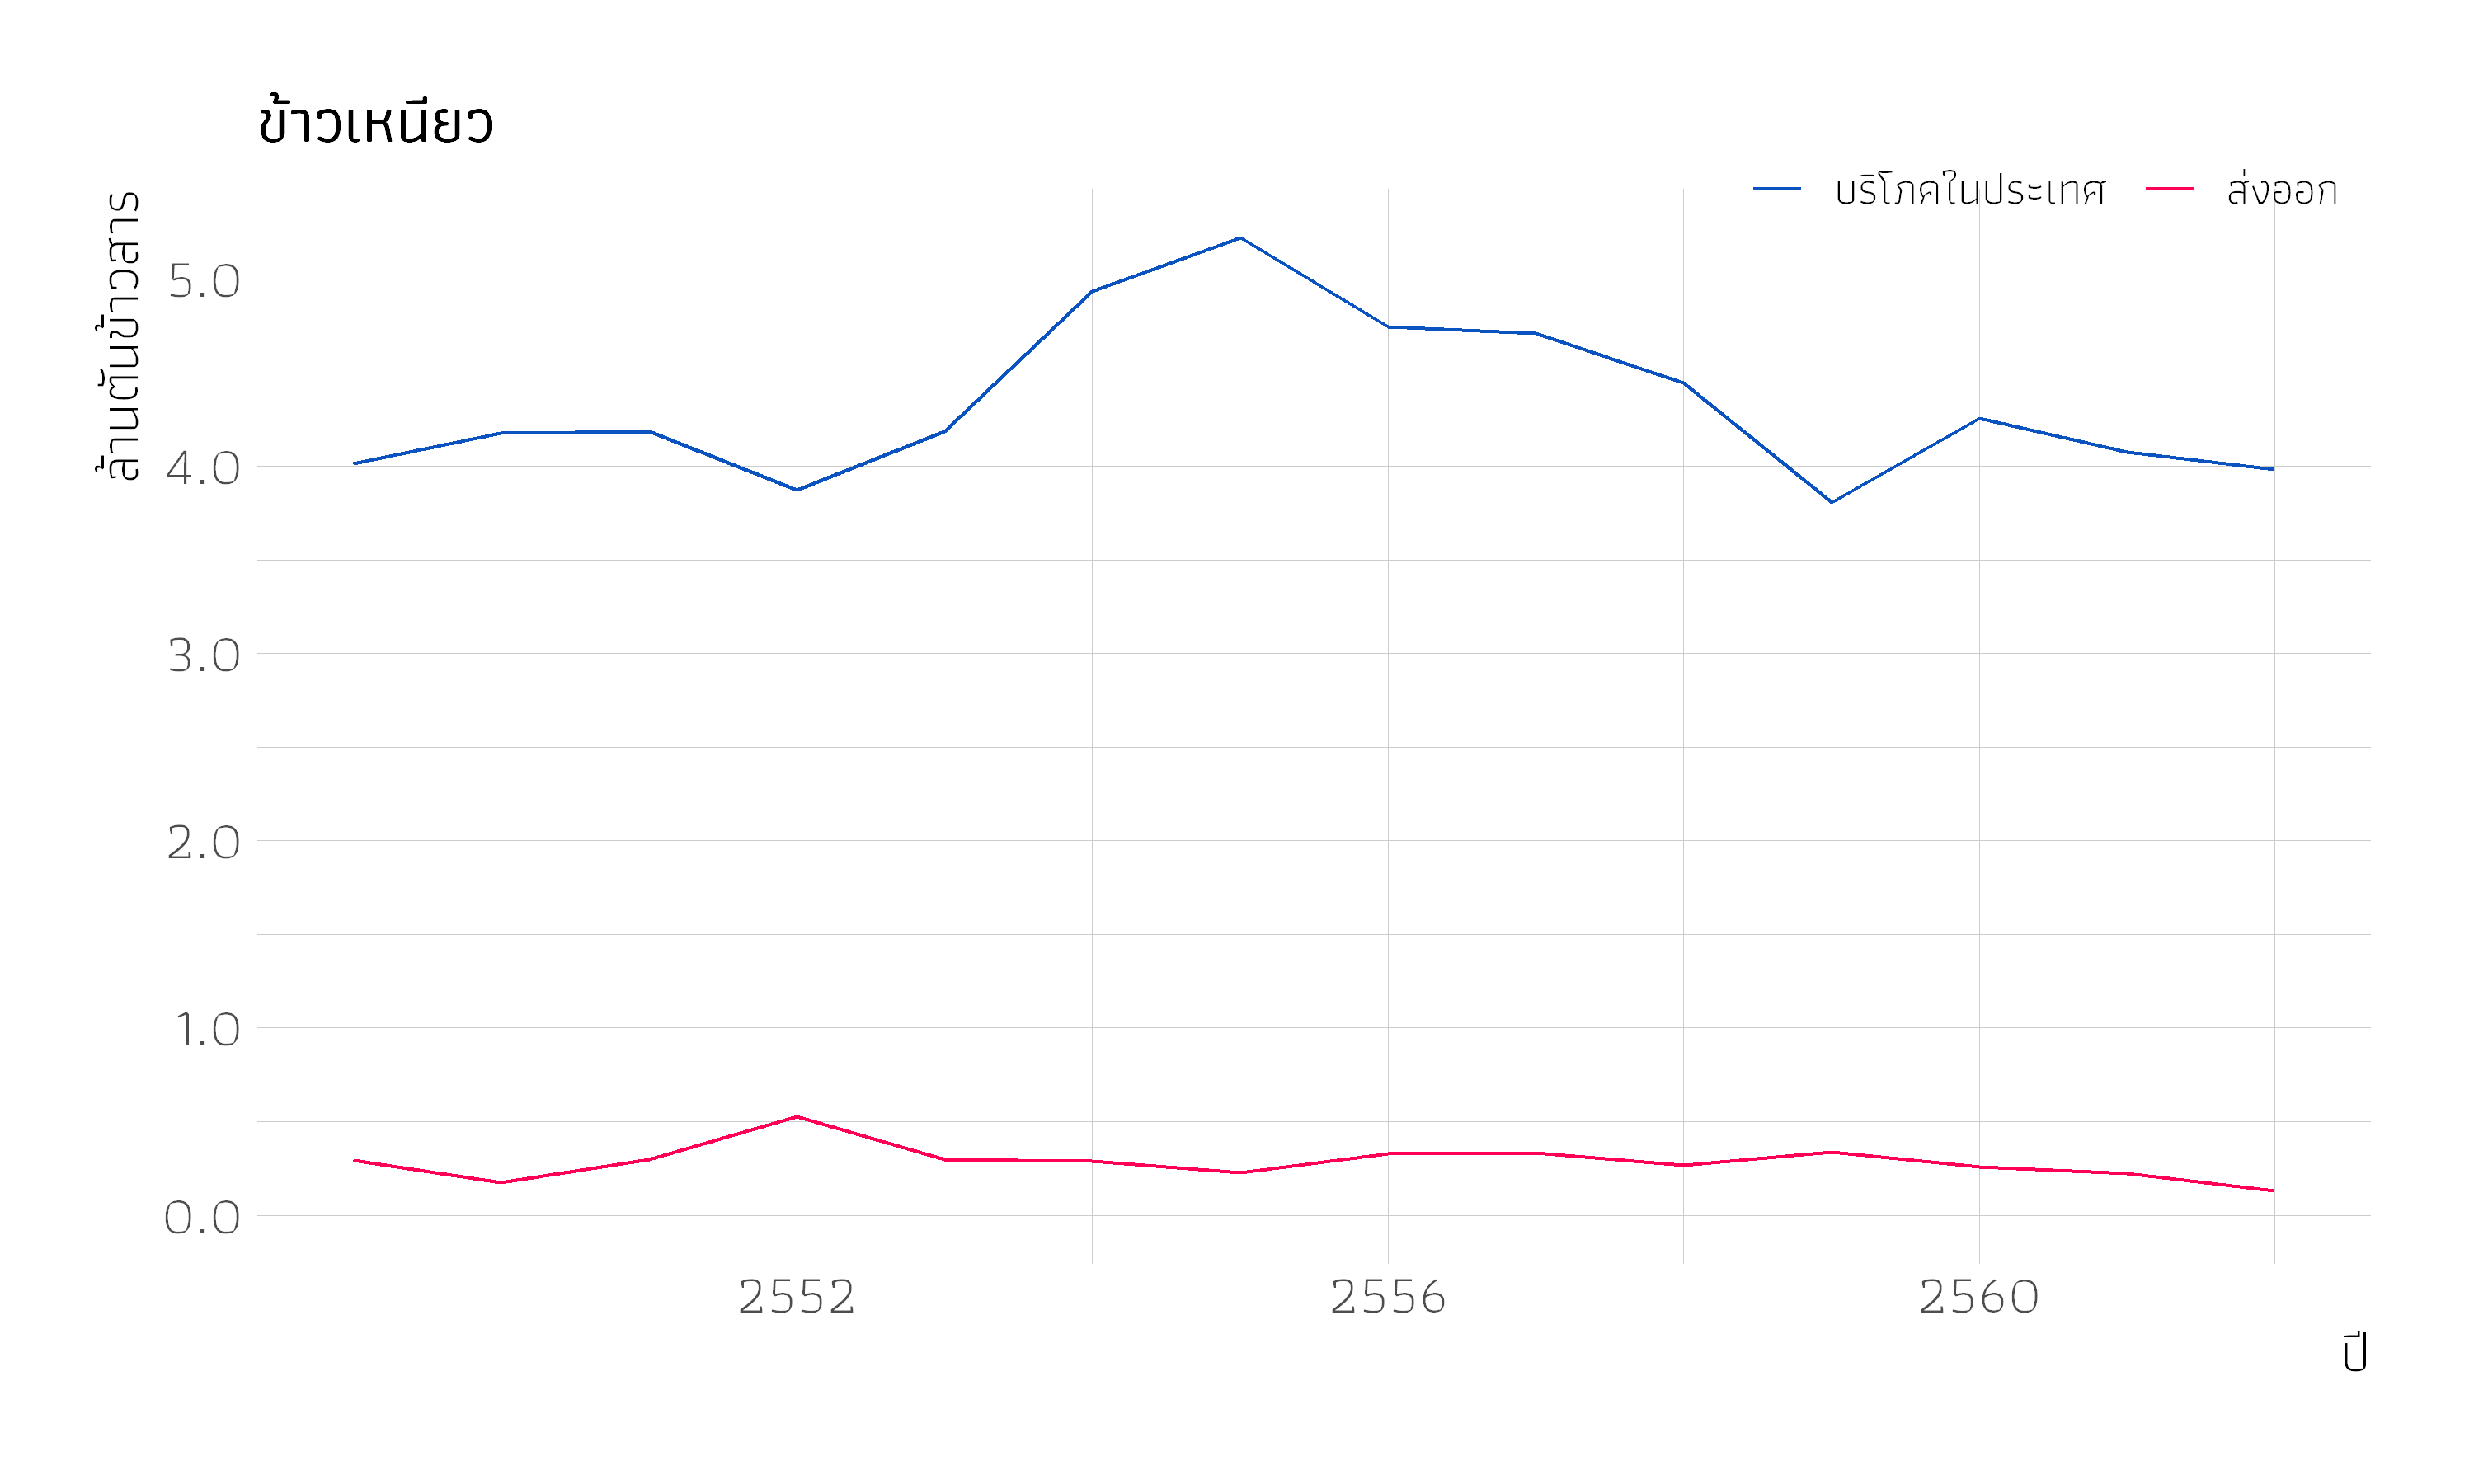

In [39]:
p_glutinous = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_glutinous/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_glutinous/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวเหนียว',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_glutinous
ggsave('../figures/plot_glutinous.png', width = 8, height = 4)

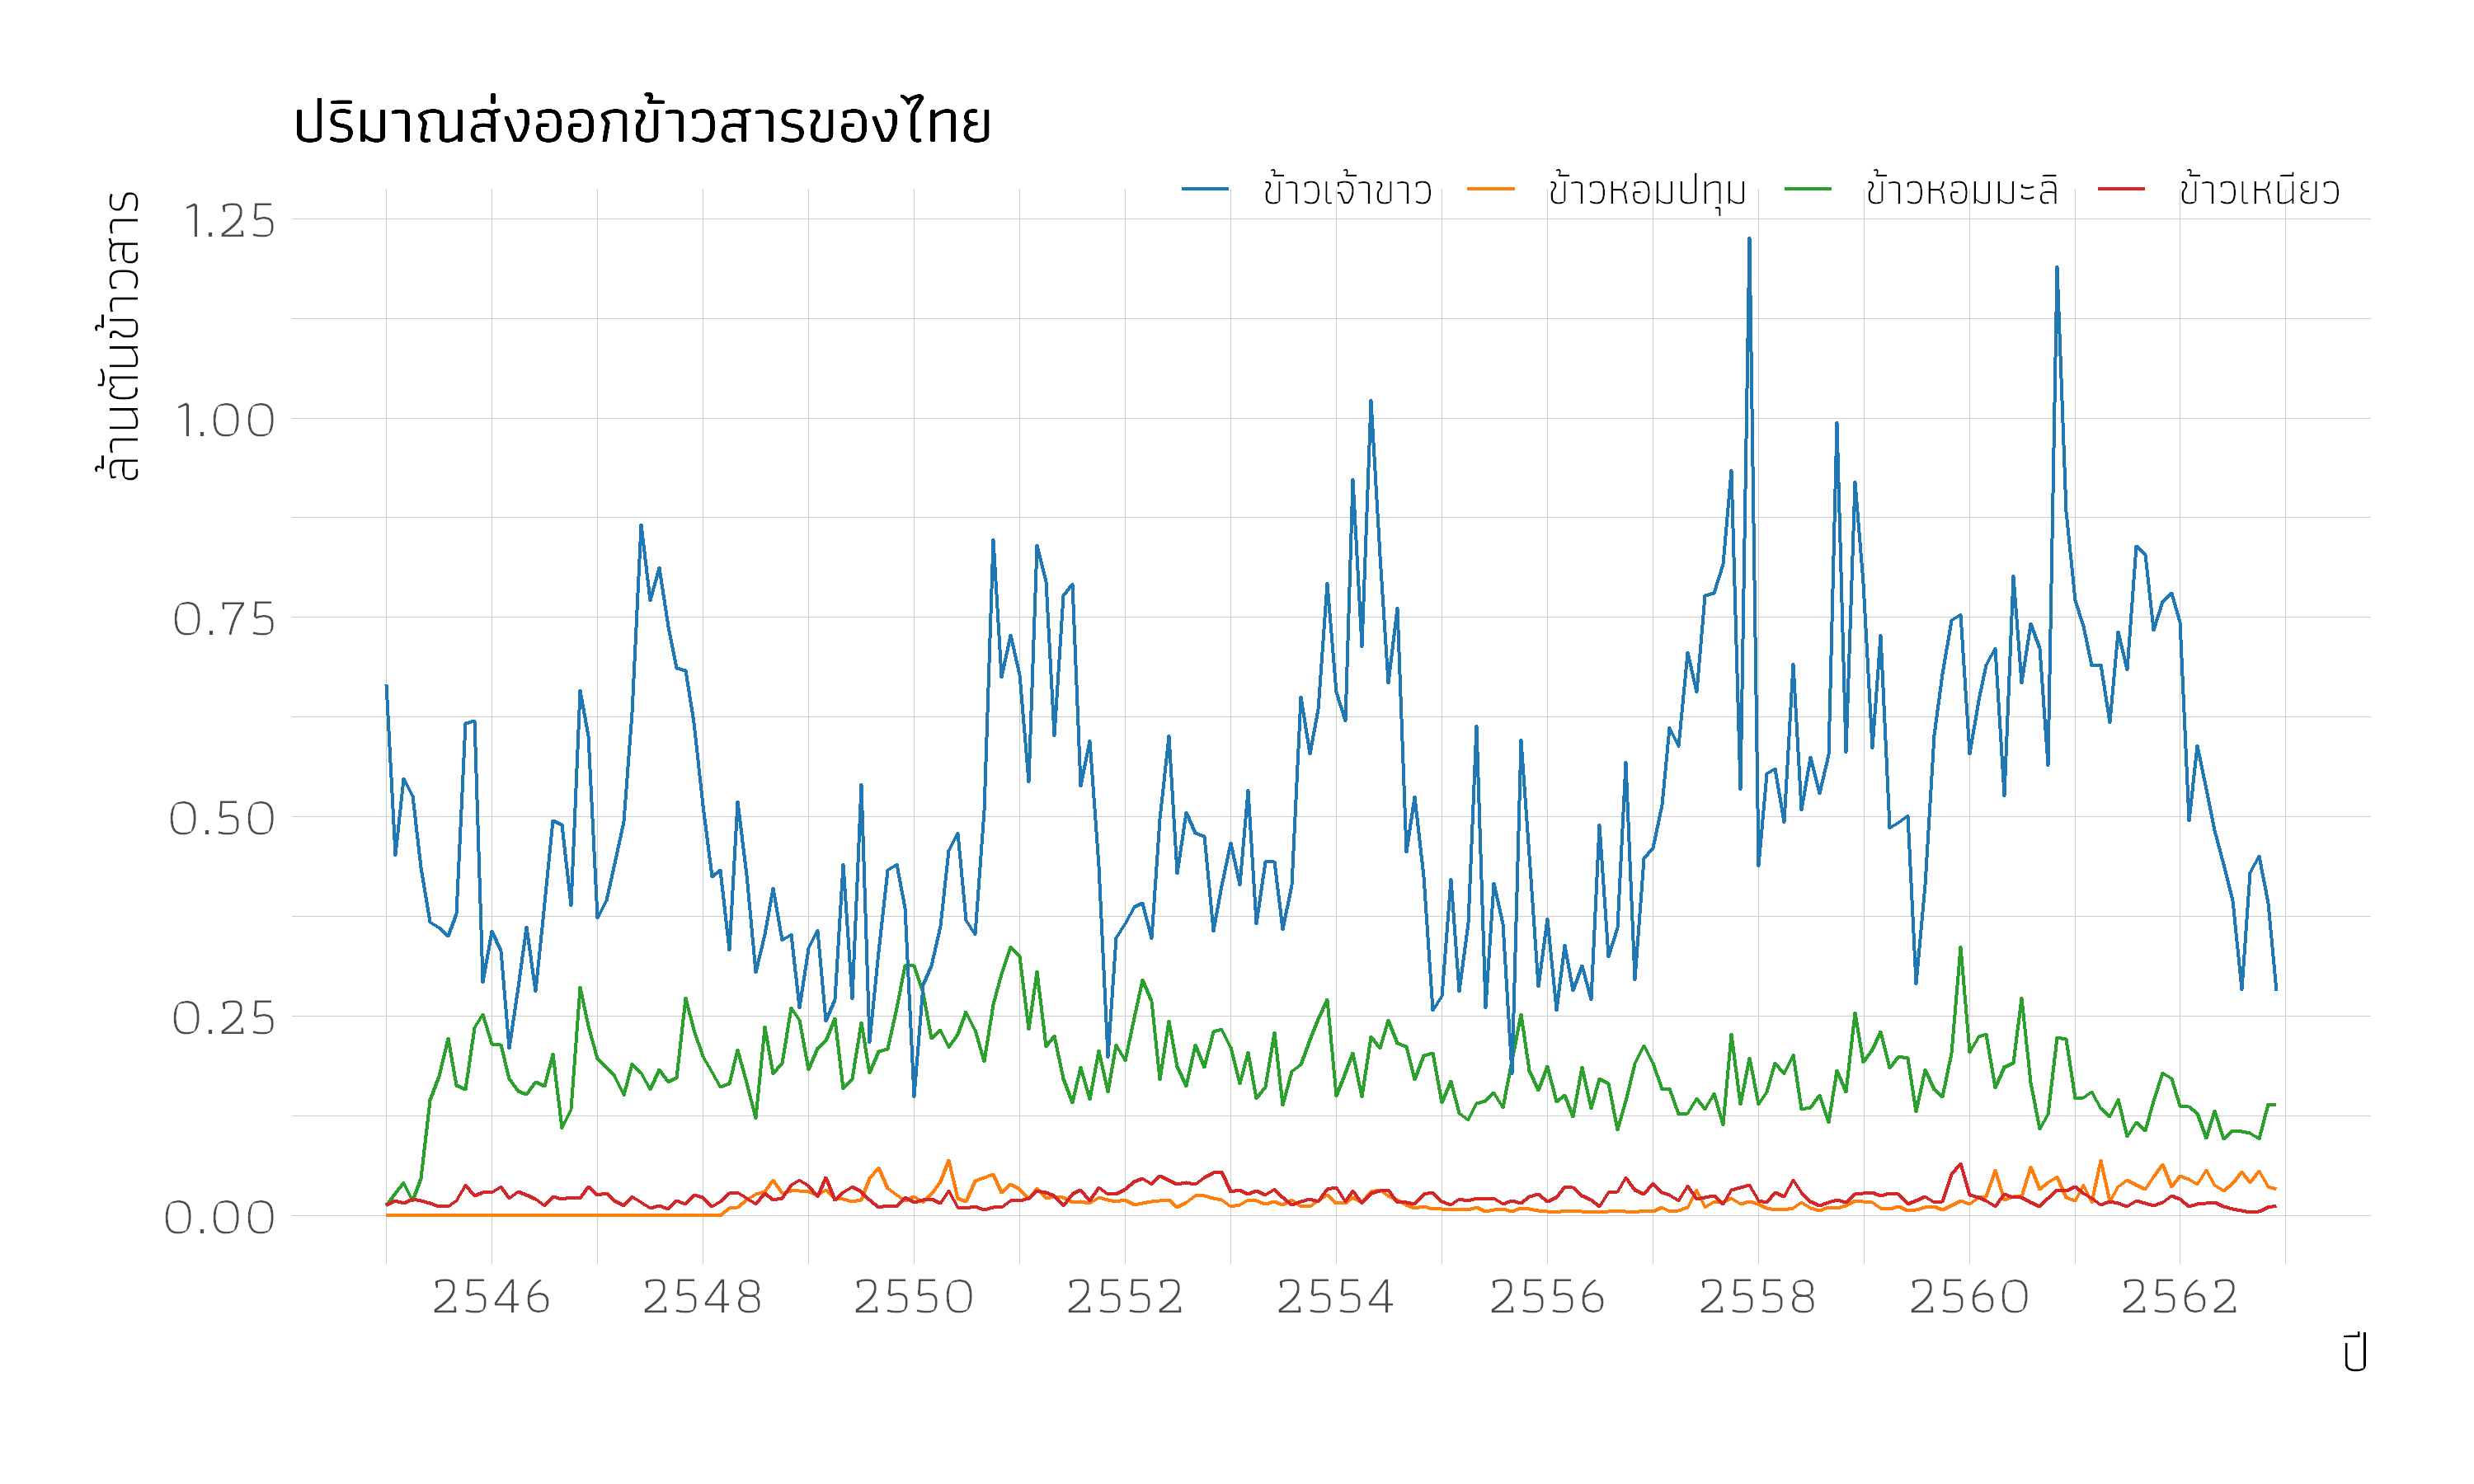

In [19]:
ggplot(rice_m, aes(x=date)) +
  geom_line( aes(y=ex_hommali/1e6, color = 'ข้าวหอมมะลิ')) +
  geom_line( aes(y=ex_pathum/1e6, color = 'ข้าวหอมปทุม')) +
  geom_line( aes(y=ex_white/1e6, color = 'ข้าวเจ้าขาว')) +
  geom_line( aes(y=ex_glutinous/1e6, color = 'ข้าวเหนียว')) +
  scale_color_d3() +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  labs(title = 'ปริมาณส่งออกข้าวสารของไทย',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  ) +
  scale_x_date(date_breaks = '2 years',
               labels = function(x) year(x)+543
               )

ggsave('../figures/plot_export_m.png', width = 10, height = 7)

## Unit Root Test

In [19]:
dom_names = c('dom_hommali', 'dom_pathum', 'dom_white', 'dom_glutinous')
data_dom = ts(data[, dom_names])

In [44]:
get_objname = function(x) deparse(substitute(x))

ur_adf = function(y, n_diff = 0, varname = NULL, ...) {
  
  varname = if (is.null(varname)) deparse(substitute(y)) else varname
  y = if(n_diff == 0) y else diff(y, n_diff)
  
  ur.trend = ur.df(y, type='trend', selectlags = "AIC", ...)
  ur.drift = ur.df(y, type='drift', selectlags = "AIC", ...)
  ur.none  = ur.df(y, type='none', selectlags = "AIC", ...)

  tstat.trend = ur.trend@teststat
  tstat.drift = ur.drift@teststat
  tstat.none  = ur.none@teststat

  cv.trend = ur.trend@cval
  cv.drift = ur.drift@cval
  cv.none  = ur.none@cval

  df_test = rbind(
    cbind(t(tstat.trend), cv.trend),
    cbind(t(tstat.drift), cv.drift),
    cbind(t(tstat.none) , cv.none)
  ) %>% 
  as.data.frame() %>%
  rownames_to_column("hypo") %>%
  mutate(
    result = ifelse(abs(statistic) >= abs(`5pct`), 'Reject', 'Accept'),
    variable = varname,
    level = paste0('d', n_diff),
    statistic = round(statistic, 2),
  ) %>%
  filter(str_starts(hypo, 'tau')) %>%
  select(variable, hypo, level, everything())
  
  return(df_test)
}

In [47]:
dom_hommali   = rice_a$dom_hommali
dom_pathum    = rice_a$dom_pathum
dom_white     = rice_a$dom_white
dom_glutinous = rice_a$dom_glutinous

ex_hommali    = rice_m_ts[, 'ex_hommali']
ex_pathum     = rice_m_ts[, 'ex_pathum'] 
ex_white      = rice_m_ts[, 'ex_white']
ex_glutinous  = rice_m_ts[, 'ex_glutinous']

rbind(ur_adf(dom_hommali, 0)  , ur_adf(dom_hommali, 1),
      ur_adf(dom_pathum, 0)   , ur_adf(dom_pathum, 1),
      ur_adf(dom_white, 0)    , ur_adf(dom_white, 1),
      ur_adf(dom_glutinous, 0), ur_adf(dom_glutinous, 1),
      ur_adf(ex_hommali, 0)   , ur_adf(ex_hommali, 1),
      ur_adf(ex_pathum, 0)    , ur_adf(ex_pathum, 1),
      ur_adf(ex_white, 0)     , ur_adf(ex_white, 1),
      ur_adf(ex_glutinous, 0) , ur_adf(ex_glutinous, 1)
     ) %>% print()

# write_excel_csv('../results/adf_table.csv')

        variable hypo level statistic  1pct  5pct 10pct result
1    dom_hommali tau3    d0     -1.83 -4.38 -3.60 -3.24 Accept
2    dom_hommali tau2    d0     -1.74 -3.75 -3.00 -2.63 Accept
3    dom_hommali tau1    d0      1.19 -2.66 -1.95 -1.60 Accept
4    dom_hommali tau3    d1     -1.75 -4.38 -3.60 -3.24 Accept
5    dom_hommali tau2    d1     -1.78 -3.75 -3.00 -2.63 Accept
6    dom_hommali tau1    d1     -1.41 -2.66 -1.95 -1.60 Accept
7     dom_pathum tau3    d0     -4.27 -4.38 -3.60 -3.24 Reject
8     dom_pathum tau2    d0     -1.36 -3.75 -3.00 -2.63 Accept
9     dom_pathum tau1    d0     -0.66 -2.66 -1.95 -1.60 Accept
10    dom_pathum tau3    d1     -1.83 -4.38 -3.60 -3.24 Accept
11    dom_pathum tau2    d1     -3.63 -3.75 -3.00 -2.63 Reject
12    dom_pathum tau1    d1     -3.10 -2.66 -1.95 -1.60 Reject
13     dom_white tau3    d0     -2.60 -4.38 -3.60 -3.24 Accept
14     dom_white tau2    d0     -2.34 -3.75 -3.00 -2.63 Accept
15     dom_white tau1    d0     -0.87 -2.66 -1.95 -1.60

ERROR: Error in write_excel_csv("../results/adf_table.csv"): is.data.frame(x) is not TRUE


## Define function

In [136]:
# fit function
fets = function(x, model='AAN', damped = FALSE, h=h) {
  forecast::ets(x, model = model, damped = damped) %>% forecast(h=h)
}

fets.auto = function(x, h=h) {
  forecast::ets(x, model = 'ZZZ', damped = NULL) %>% forecast(h=h)
}

farima = function(x, order = c(0,0,0), seasonal = c(0,0,0), h=h) {
  forecast::Arima(x,
                  order = order, 
                  seasonal = seasonal,
                 ) %>% forecast(h=h)
}

farima.auto = function(x, d=0, h=h) {
  forecast::auto.arima(x, d=d) %>% forecast(h=h)
}


# accuracy measurement
rmse = function(data, h = h) {
  data = data %>% select('actual', starts_with('yhat')) %>% exp()
  h = ncol(data) - 1
  for (i in seq(h)) {
    data[, paste0('e', i)] = (
      lead(data[,'actual'], i) - data[, paste0('yhat', i)]
    )^2
  }
  rmse_score = data %>% select(starts_with('e')) %>% 
    as.matrix() %>% mean(na.rm = TRUE) %>% sqrt()
  
  return(rmse_score)
}

mape = function(data, h = h) {
  data = data %>% select('actual', starts_with('yhat')) %>% exp()
  h = ncol(data) - 1
  for (i in seq(h)) {
    data[, paste0('e', i)] = abs(
      lead(data[,'actual'], i) - data[, paste0('yhat', i)]
    )*100 / lead(data[,'actual'], i)
  }
  mape_score = data %>% select(starts_with('e')) %>% 
    as.matrix() %>% mean(na.rm = TRUE)
  
  return(mape_score)
}

eval_ets = function(x, params, h = 2, initial = 11) {
  pmap(
    list(params$model, params$damped), 
    function(first, second) {
      
      # 1 compute forecast error using time series cross validation
      error = tsCV(x, fets, h = h, initial = initial, 
                   model = first, 
                   damped = second
                  ) %>% as.data.frame()
      new_colnames = c('actual', paste0('e', seq(1:h)))
      error = data.frame(x, error) %>% set_names(new_colnames)
      
      # 2 compute predicted (yhat)
      for (i in seq(h)) {
        error[, paste0('yhat', i)] = (
          lead(error[,'actual'], i) - error[, paste0('e', i)]
        )
      }
      
      # 3 compute rmse, mape
      data.frame(
        model = paste(first, second, sep = '-'),
        rmse = rmse(error),
        mape = mape(error)
      ) %>% na.omit()
    }
  ) %>% 
  reduce(bind_rows) %>%
  arrange(rmse)
}

eval_arima = function(x, params, h = 2, initial = 11) {
  pmap(
    list(params$order, params$seasonal), 
    function(first, second) {
      
      # 1 compute forecast error using time series cross validation
      error = tsCV(x, farima, h = h, initial = initial, 
                   order = first, 
                   seasonal = second
                  ) %>% as.data.frame()
      new_colnames = c('actual', paste0('e', seq(1:h)))
      error = data.frame(x, error) %>% set_names(new_colnames)
      
      # 2 compute predicted (yhat)
      for (i in seq(h)) {
        error[, paste0('yhat', i)] = (
          lead(error[,'actual'], i) - error[, paste0('e', i)]
        )
      }
  
      # 3 compute rmse, mape
      data.frame(
        model = paste(paste(first, collapse = ','), 
                      paste(second, collapse = ','), sep = '-'),
        rmse = rmse(error),
        mape = mape(error)
      ) %>% na.omit()
    }
  ) %>% 
  reduce(bind_rows) %>%
  arrange(rmse)
}

## Domestic

In [156]:
Z1 = c('A','M')
Z2 = c('N', 'A', 'M')
Z3 = c('N')
damped = c(FALSE, TRUE)

ets_params = expand.grid(Z1, Z2, Z3, damped) %>%
  mutate(
    model = paste0(Var1, Var2, Var3),
    damped = Var4
) %>% select(model, damped)

In [157]:
length(dom_hommali) * 0.8

[1] 11.2

In [167]:
h = 1

e.ets.dom_hml = eval_ets(
  dom_hommali %>% log(), params = ets_params, h = h, initial = 11
)
e.ets.dom_pat = eval_ets(
  dom_pathum %>% log(), params = ets_params, h = h, initial = 11
)
e.ets.dom_wht = eval_ets(
  dom_white %>% log(), params = ets_params, h = h, initial = 11
)
e.ets.dom_glu = eval_ets(
  dom_glutinous %>% log(), params = ets_params, h = h, initial = 11
)

## Export

In [159]:
# ETS params
Z1 = c('A','M')
Z2 = c('N', 'A', 'M')
Z3 = c('N', 'A', 'M')
damped = c(FALSE, TRUE)

ets_params = expand.grid(Z1, Z2, Z3, damped) %>%
  mutate(
    model = paste0(Var1, Var2, Var3),
    damped = Var4
) %>% select(model, damped)


# ARIMA params
p = seq(0,2)
q = seq(0,2)
P = seq(0,1)
Q = seq(0,1)

arima_params = expand.grid(p,q,P,Q) %>% rowwise() %>%
  mutate(
    order = pmap(list(Var1, Var2), function(x, y) c(x, 0, y)),
    seasonal = pmap(list(Var3, Var4), function(x, y) c(x, 0, y)),
  ) %>% select(order, seasonal)

In [160]:
length(ex_hommali) * 0.8 / 12
11*12

[1] 11.2

[1] 132

In [164]:
h = 1
initial = 132

e.ets.ex_hml = eval_ets(
  ex_hommali %>% log(), params = ets_params, h = h, initial = initial
)
e.ets.ex_pat = eval_ets(
  ex_pathum %>% log(), params = ets_params, h = h, initial = initial
)
e.ets.ex_wht = eval_ets(
  ex_white %>% log(), params = ets_params, h = h, initial = initial
)
e.ets.ex_glu = eval_ets(
  ex_glutinous %>% log(), params = ets_params, h = h, initial = initial
)

In [165]:
e.arima.ex_hml = eval_arima(
  ex_hommali %>% log(), params = arima_params, h = h, initial = initial
)
e.arima.ex_pat = eval_arima(
  ex_pathum %>% log(), params = arima_params, h = h, initial = initial
)
e.arima.ex_wht = eval_arima(
  ex_white %>% log(), params = arima_params, h = h, initial = initial
)
e.arima.ex_glu = eval_arima(
  ex_glutinous %>% log(), params = arima_params, h = h, initial = initial
)

In [166]:
acc_ex_hml1 = list(ets = e.ets.ex_hml, e.arima.ex_hml)
acc_ex_pat1 = list(ets = e.ets.ex_pat, e.arima.ex_pat)
acc_ex_wht1 = list(ets = e.ets.ex_wht, e.arima.ex_wht)
acc_ex_glu1 = list(ets = e.ets.ex_glu, e.arima.ex_glu)

In [163]:
acc_ex_hml = list(ets = e.ets.ex_hml, e.arima.ex_hml)
acc_ex_pat = list(ets = e.ets.ex_pat, e.arima.ex_pat)
acc_ex_wht = list(ets = e.ets.ex_wht, e.arima.ex_wht)
acc_ex_glu = list(ets = e.ets.ex_glu, e.arima.ex_glu)

In [ ]:
fets <- function(x, model='AAN', damped = FALSE, h=1) {
  forecast(ets(x, model=model, damped = damped), h=h)
}

farima <- function(x, d, h=1) {
  forecast(auto.arima(x, d=d), h=h)
}

In [ ]:
fets <- function(x, model='ZZZ', damped = NULL, h=2) {
  forecast(ets(x, model=model, damped = damped), h=h)
}

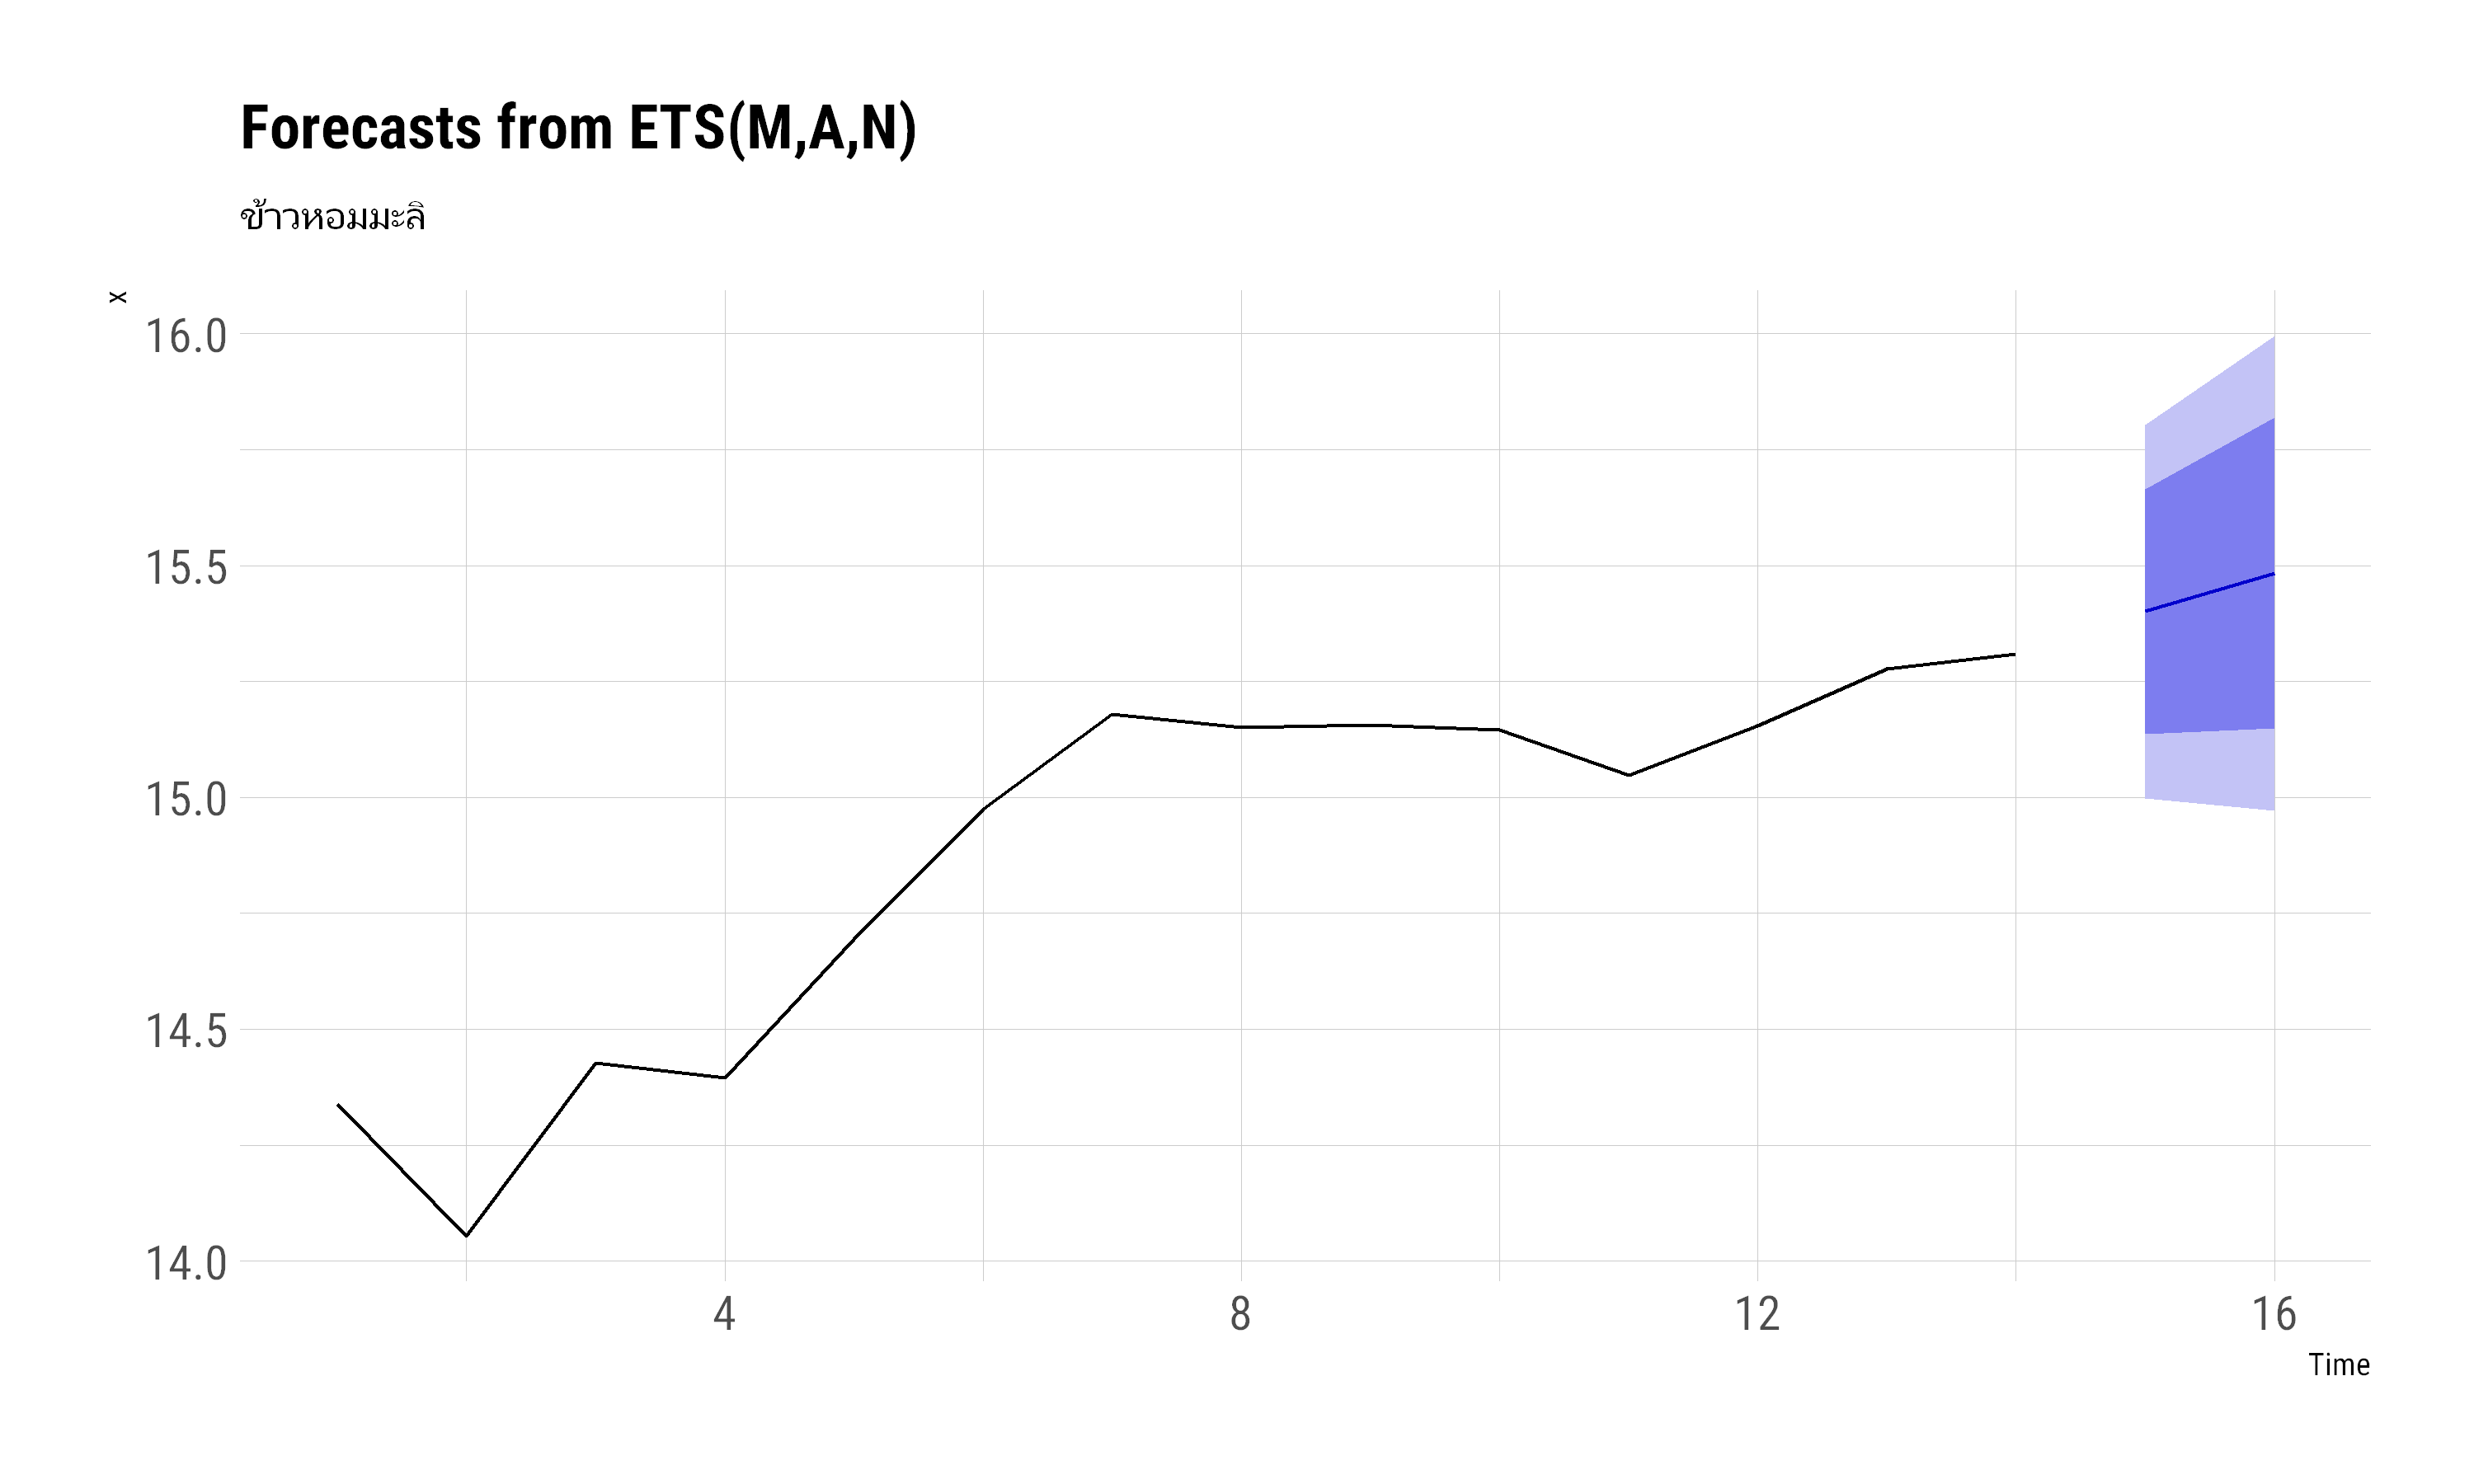

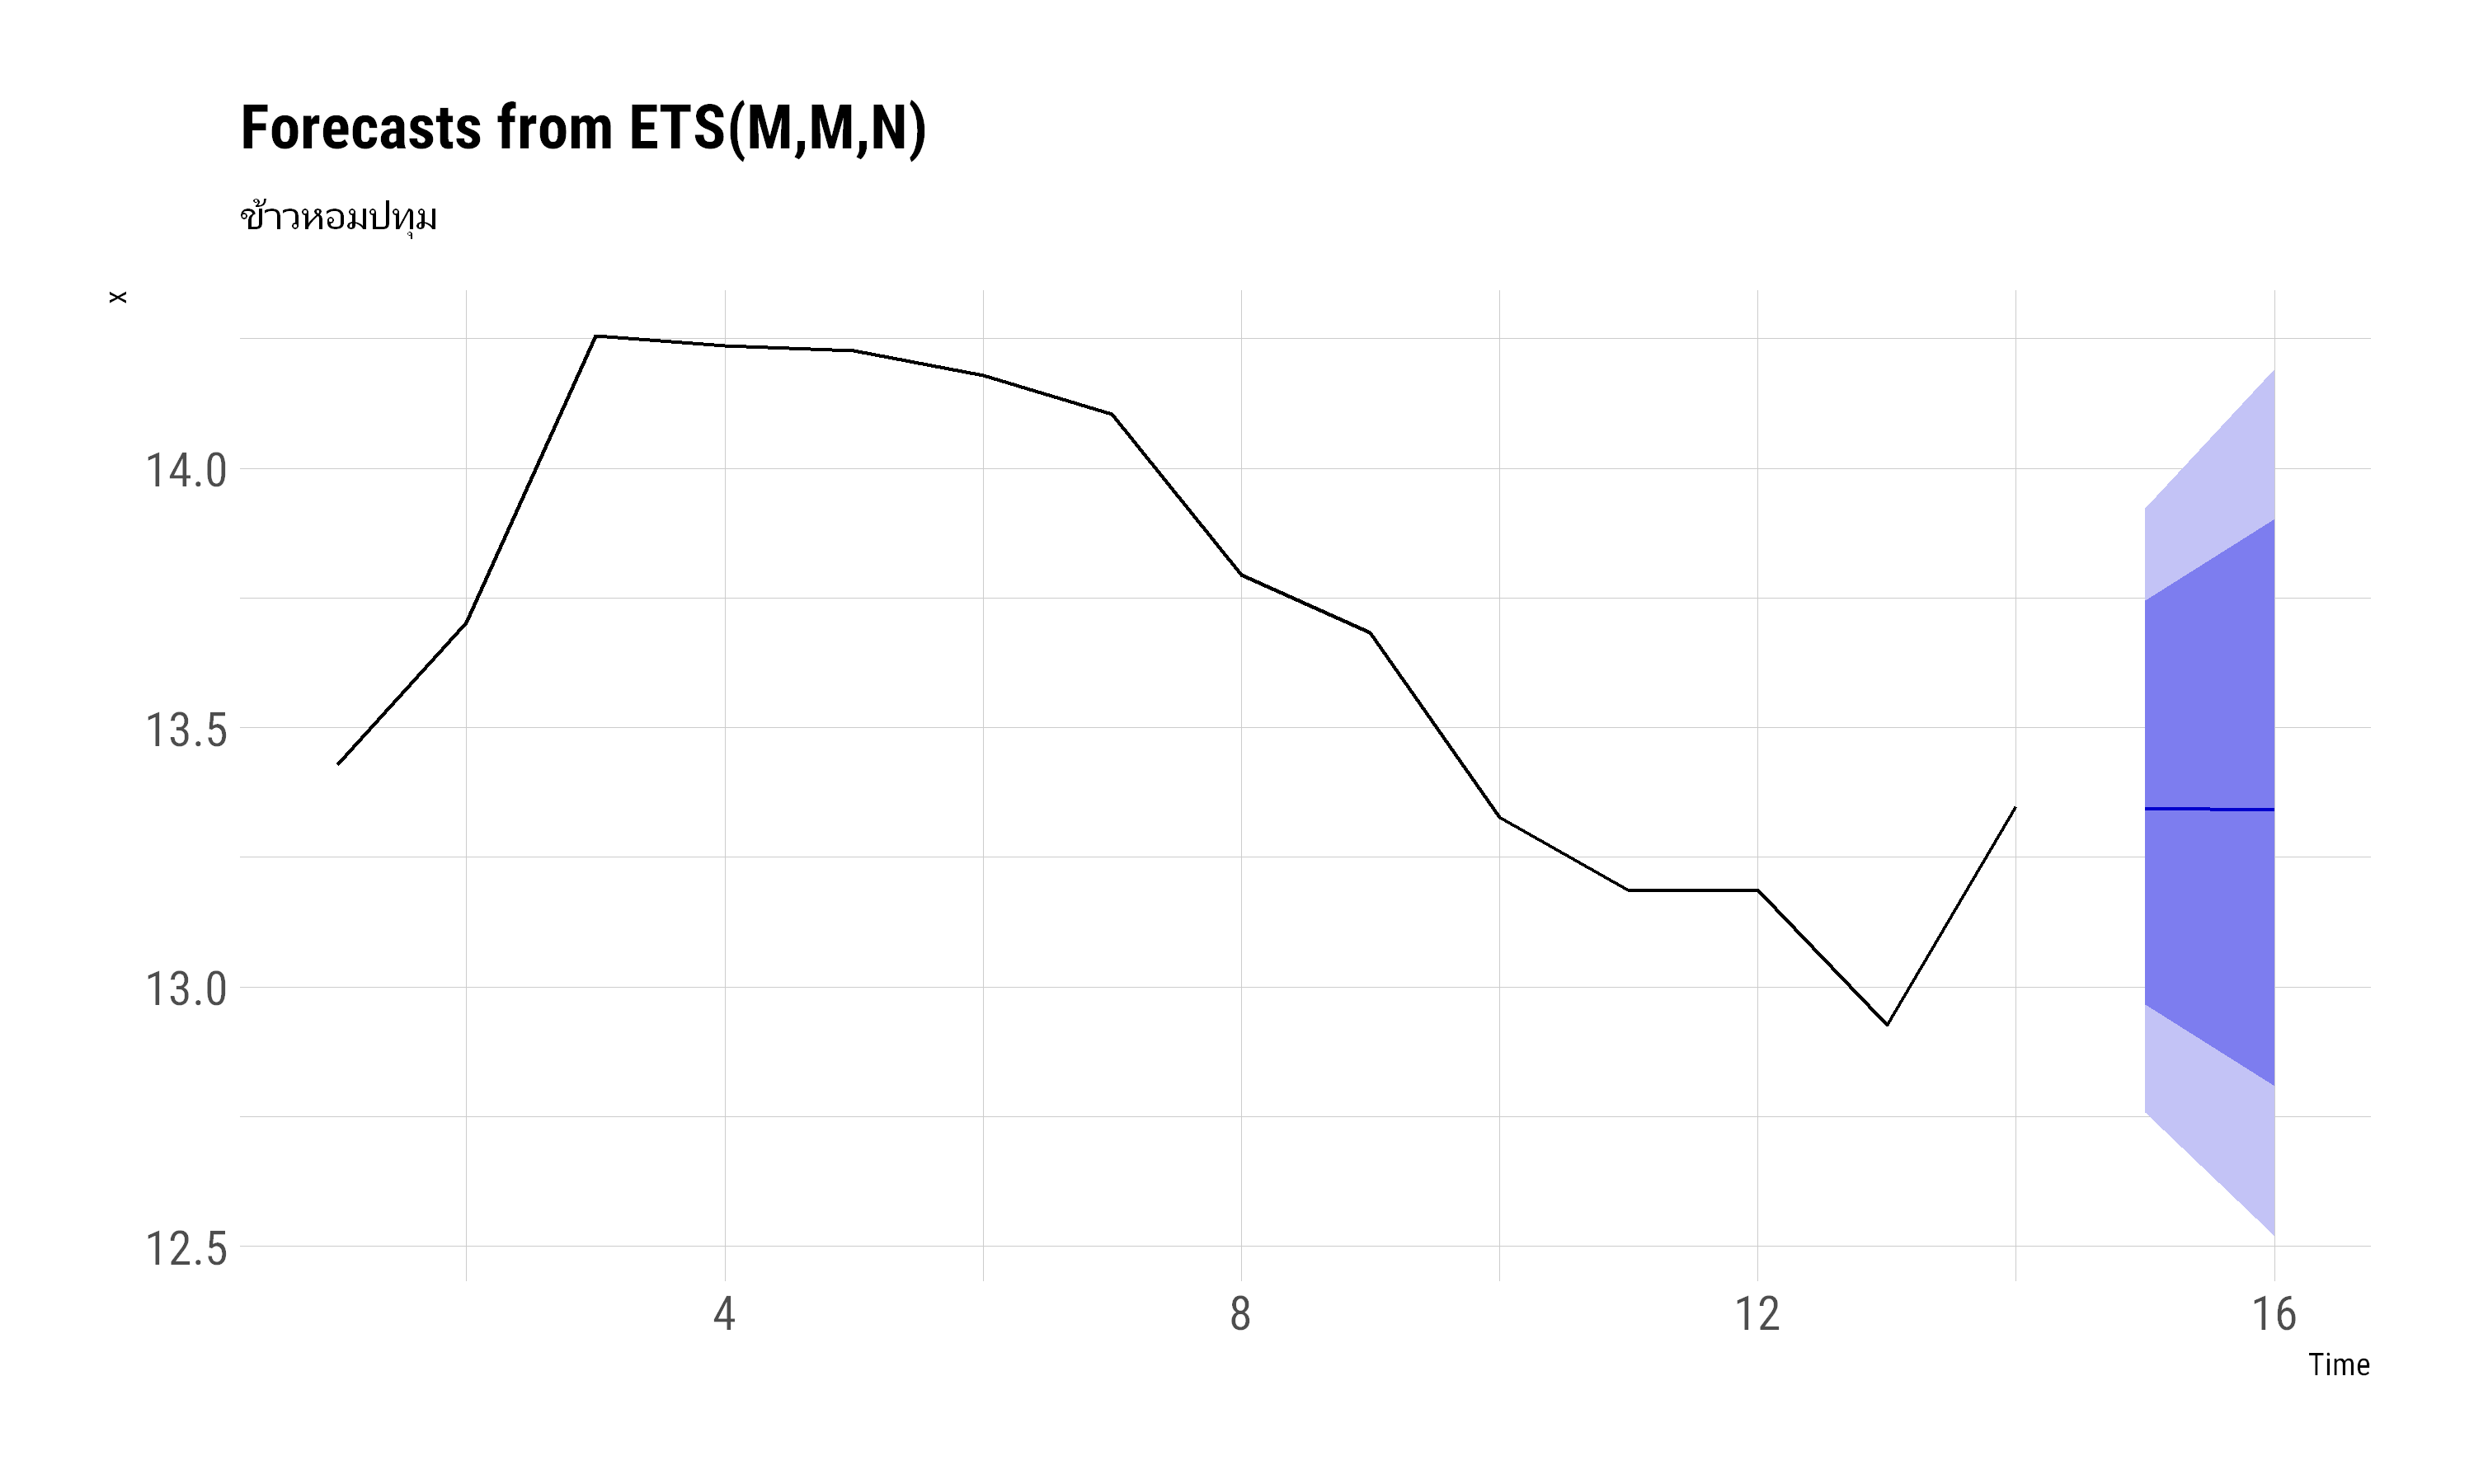

In [174]:
fets(dom_hommali %>% log(), model='MAN', damped = FALSE, h=2) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวหอมมะลิ')
ggsave('../figures/plot_ets_hommali_d.png', width = 8, height = 5)

fets(dom_pathum %>% log(), model='MMN', damped = FALSE, h=2) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวหอมปทุม')
ggsave('../figures/plot_ets_pathum_d.png', width = 8, height = 5)

fets(dom_white %>% log(), model='ANN', damped = FALSE, h=2) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวเจ้าขาว')
ggsave('../figures/plot_ets_white_d.png', width = 8, height = 5)

fets(dom_glutinous %>% log(), model='ANN', damped = FALSE, h=2) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวเหนียว')
ggsave('../figures/plot_ets_glutinous_d.png', width = 8, height = 5)

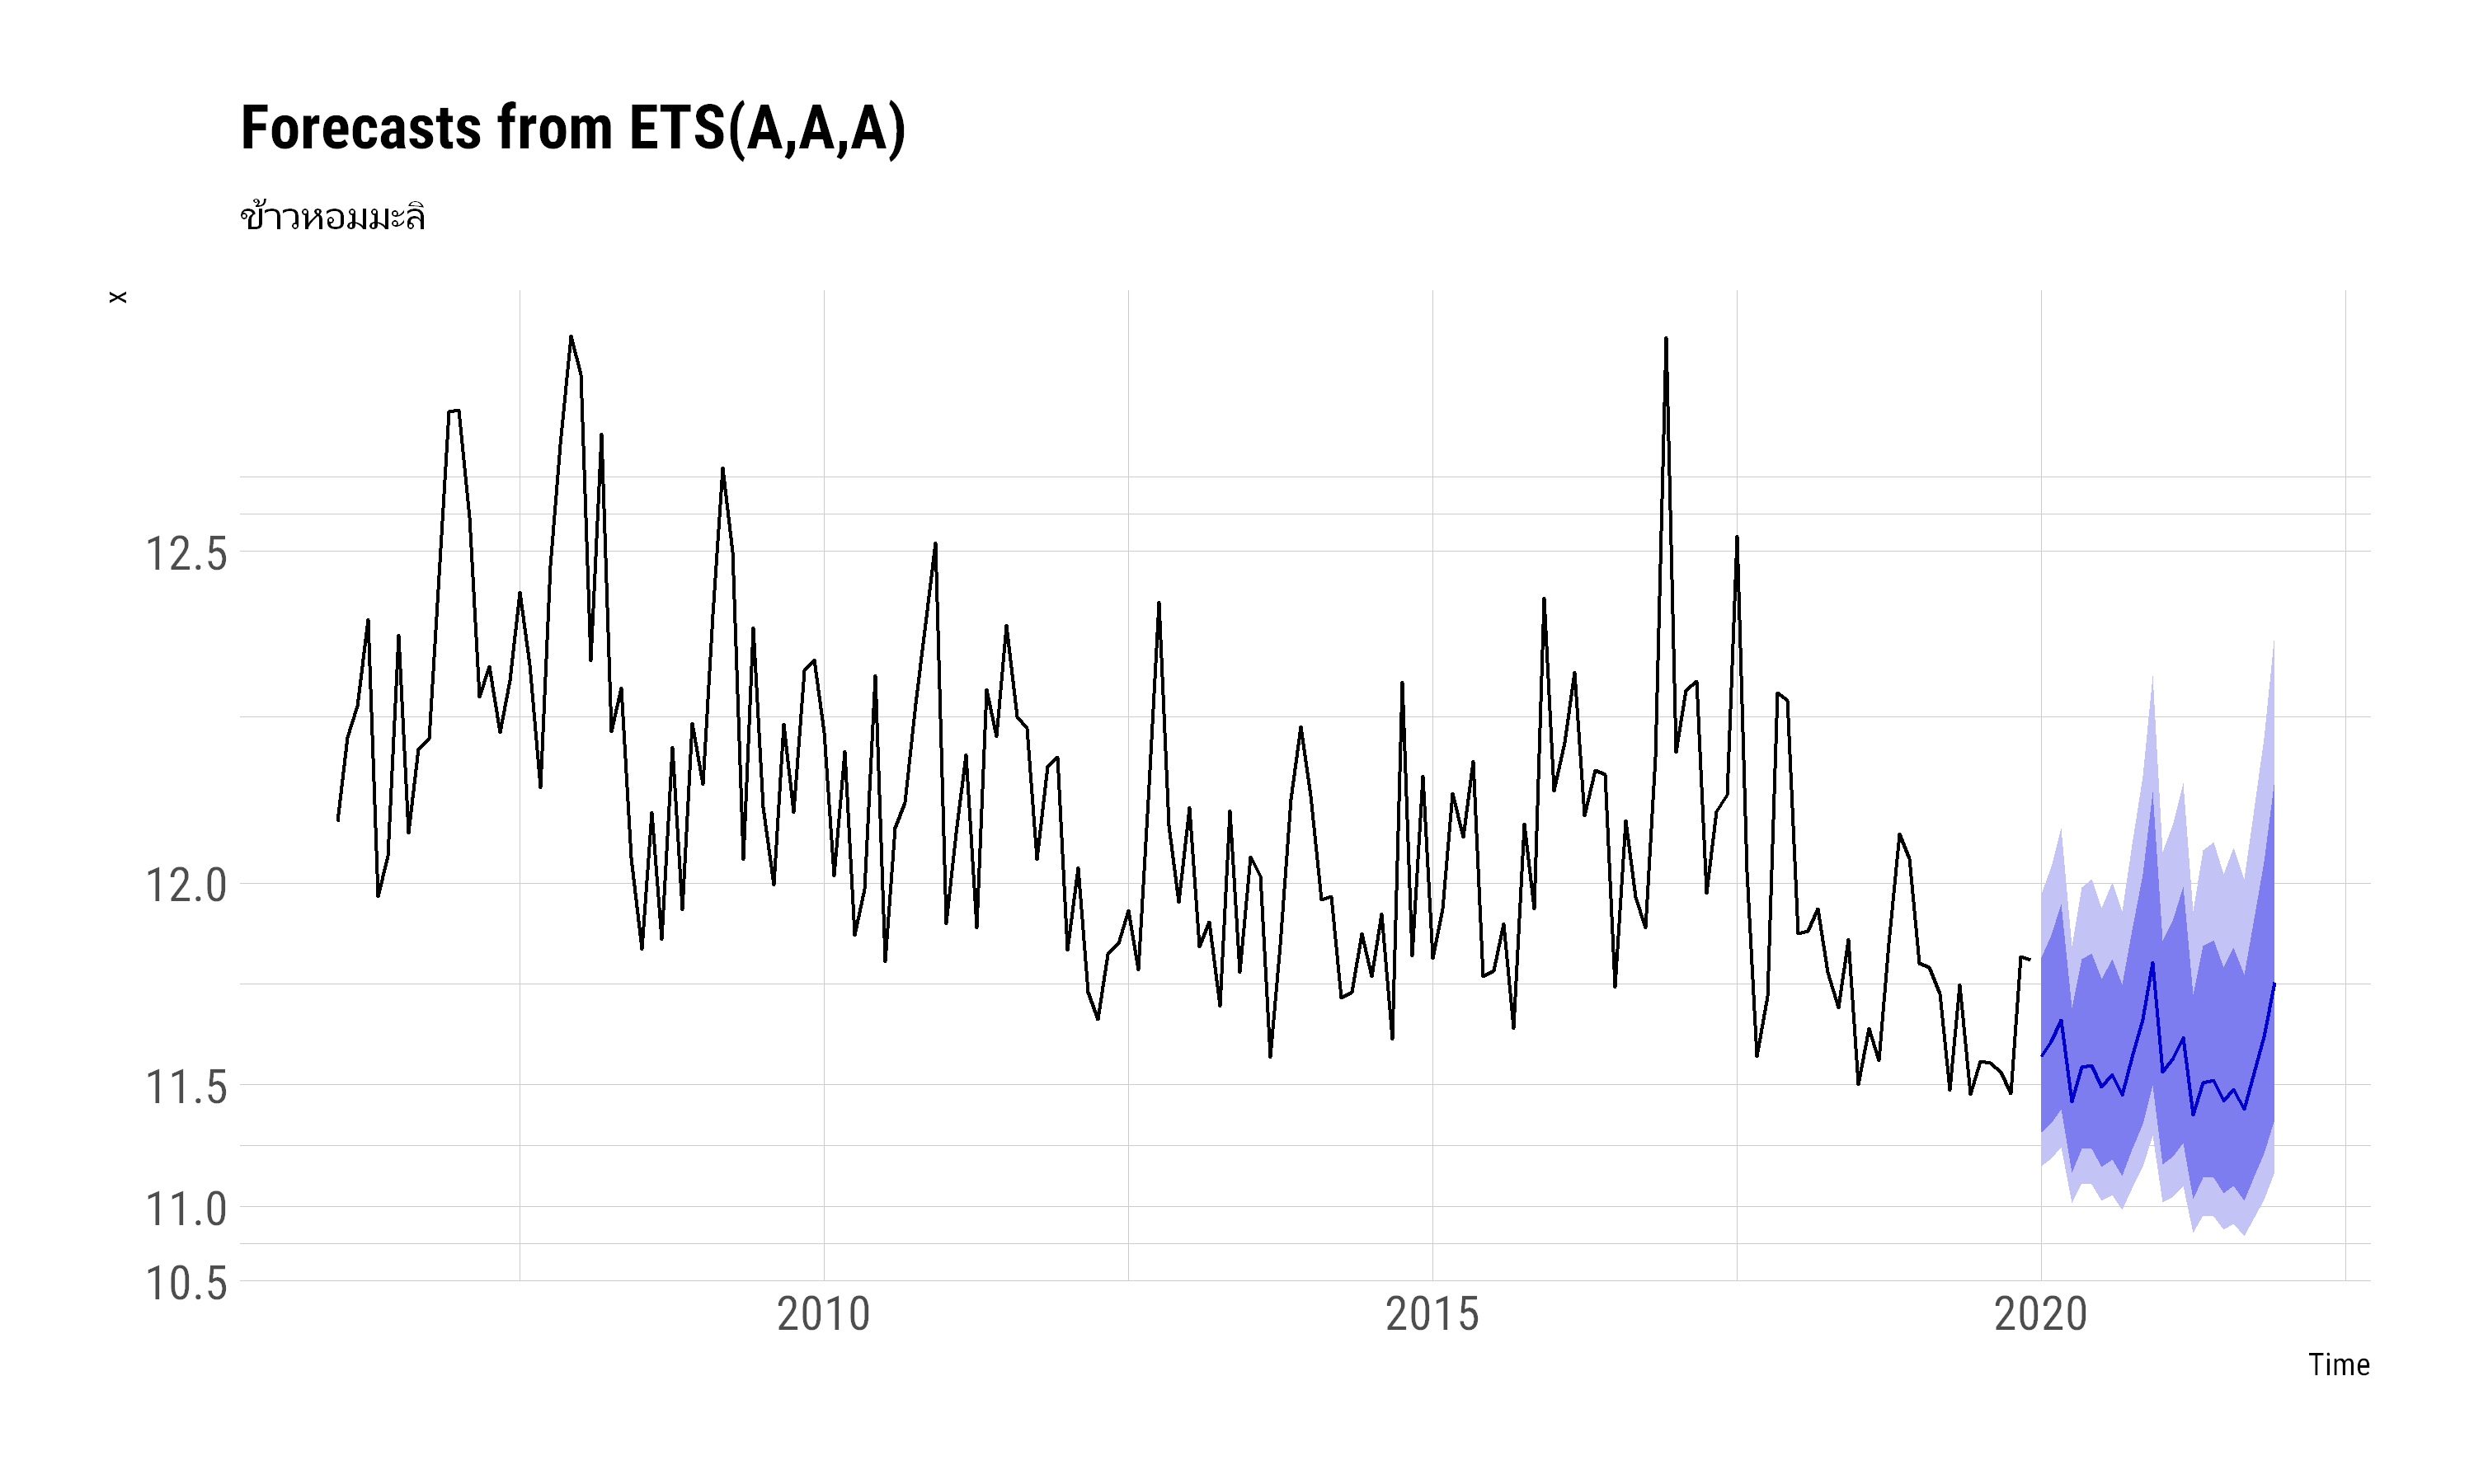

In [182]:
fets(ex_hommali %>% log(), model = 'AAA', damped = FALSE, h = 24) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวหอมมะลิ')
ggsave('../figures/plot_ets_hommali_ex.png', width = 8, height = 5)

# farima(ex_pathum %>% log(), 
#        order = c(1,0,1), seasonal = c(1,0,1), h = 24) %>% 
#   autoplot() +
#   theme_ipsum_rc(base_size = 14) + 
#   labs(subtitle = 'ข้าวหอมปทุม')
# ggsave('../figures/plot_ets_pathum_ex.png', width = 8, height = 5)

# fets(ex_white %>% log(), model = 'ANN', damped = FALSE, h = 24) %>% 
#   autoplot() +
#   theme_ipsum_rc(base_size = 14) + 
#   labs(subtitle = 'ข้าวเจ้าขาว')
# ggsave('../figures/plot_ets_white_ex.png', width = 8, height = 5)

# farima(ex_glutinous %>% log(), 
#        order = c(2,0,1), 
#        seasonal = c(1,0,1), h = 24) %>% 
#   autoplot() +
#   theme_ipsum_rc(base_size = 14) + 
#   labs(subtitle = 'ข้าวเหนียว')
# ggsave('../figures/plot_ets_glutinous_ex.png', width = 8, height = 5)

In [189]:
fets(ex_hommali %>% log(), model = 'AAA', damped = FALSE, h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_hml.csv')

farima(ex_pathum %>% log(), 
       order = c(1,0,1), seasonal = c(1,0,1), h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_pat.csv')

fets(ex_white %>% log(), model = 'ANN', damped = FALSE, h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_wht.csv')

farima(ex_glutinous %>% log(), 
       order = c(2,0,1), 
       seasonal = c(1,0,1), h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_glu.csv')

In [190]:
fets(dom_hommali %>% log(), model='MAN', damped = FALSE, h=2) %>% 
  as.data.frame() %>%
  write_excel_csv('../results/dom_hml.csv')

fets(dom_pathum %>% log(), model='MMN', damped = FALSE, h=2) %>% 
  as.data.frame() %>%
  write_excel_csv('../results/dom_pat.csv')

fets(dom_white %>% log(), model='ANN', damped = FALSE, h=2) %>% 
  as.data.frame() %>%
  write_excel_csv('../results/dom_wht.csv')

fets(dom_glutinous %>% log(), model='ANN', damped = FALSE, h=2) %>% 
  as.data.frame() %>%
  write_excel_csv('../results/dom_glu.csv')

In [ ]:
fets(log(ts_export[,'ex_hommali']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_ets_exp_hml.png', width = 8, height = 5)

fets(log(ts_export[,'ex_pathum']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_ets_exp_pat.png', width = 8, height = 5)

fets(log(ts_export[,'ex_white']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_ets_exp_wht.png', width = 8, height = 5)

fets(log(ts_export[,'ex_glutinous']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_ets_exp_glu.png', width = 8, height = 5)

## ARIMA

In [ ]:
farima <- function(x, d, h=2) {
  forecast(auto.arima(x, d=d), h=h)
}

In [ ]:
farima(log(data$dom_hommali), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_arima_dom_hml.png', width = 8, height = 4)

farima(log(data$dom_pathum), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_arima_dom_pat.png', width = 8, height = 4)

farima(log(data$dom_white), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_arima_dom_wht.png', width = 8, height = 4)

farima(log(data$dom_glutinous), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_arima_dom_glu.png', width = 8, height = 4)

In [ ]:
farima(log(ts_export[, 'ex_hommali']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_arima_exp_hml.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_pathum']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_arima_exp_pat.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_white']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_arima_exp_wht.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_glutinous']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_arima_exp_glu.png', width = 8, height = 4)

In [ ]:
# Compute CV errors for ETS as e1
e1 <- tsCV(log(data$dom_hommali), fets, h=2, initial = 10)
# Compute CV errors for ARIMA as e2
e2 <- tsCV(log(data$dom_hommali), farima, d=1, h=2, initial = 10)

# MSE
# sqrt(mean(e1[10:13,]^2))
# sqrt(mean(e2[10:13,]^2))

# # MAE
# mean(abs(e1[10:13,]))
# mean(abs(e2[10:13,]))

In [ ]:
forecast(ets(log(data$ex_hommali)), h = 2)

In [ ]:
forecast(auto.arima(log(data$dom_glutinous), d = 1), h = 2) %>% autoplot()

## VAR

In [ ]:
VARselect(ts_export)

In [ ]:
ca.jo(ts_export, ecdet = 'const', K = 4, season = 12) %>% summary()

In [ ]:
vecm_export = VAR(diff(ts_export), p = 4, type = 'const', season = 12)

In [ ]:
serial.test(vecm_export, lags.pt=12, type="PT.asymptotic")

In [ ]:
forecast(vecm_export, h = 24) %>% autoplot()
ggsave('../figures/plot_vecm_exp.png', width = 14, height = 8)